# Pergamino {.unnumbered}

The goal of our analysis here in Pergamino is to assess heat risk across the larger area, particularly in urban contexts. 

In [1]:
# final steps:

# state objectives
# assess heat across the department by land cover--just simple distribution
# focus in on populated areas: spatially filter, then assess distribution of heat across three classes (rural, periurban, urban)
# periurban areas:
# map hotspots
# quantify risk (total pop, pop in material poverty)
# assess drivers
# land cover
# tree cover
# built volume
# distance to water
# neighbor effects
# urban areas:
# map hotspots
# quantify risk (total pop, pop in material poverty)
# assess drivers
# land cover
# tree cover
# built volume
# distance to water
# neighbor effects
# recommendations (drawn heavily from WRI material):
# for periurban areas
# for urban areas

A SPECIFIC PROBLEM WITH A SPECIFIC SOLUTION IS THAT MANY OF THE PARKS ARE ACTUALLY AMONG THE HOTEST PLACES BECAUSE THEY LACK ADEQUATE TREE COVER. THIS SHOULD BE REMEDIED.

This WRI article to explain _long-term impact of heat under climate change_: https://www.wri.org/insights/climate-change-effects-cities-15-vs-3-degrees-C

Other factors, e.g., "Incidence of arboviruses such as dengue, Zika, West Nile, yellow fever and chikungunya will likely increase worldwide as days with optimal temperatures for disease-carrying mosquitos become more common.

Comparing 1.5 degrees C and 3 degrees C of warming, the average increase in peak arbovirus-transmission days globally is 6 days. But the picture is much more complicated than the global average."

"Arboviruses are of particularly urgent concern in Latin America. Brazil is already experiencing a dengue crisis, and at 3 degrees C of warming, 11 of its largest cities could see high arbovirus risk for at least six months of the year. Rio de Janeiro may see significantly more illness if global warming reaches 3 degrees C, as the expected number of peak arbovirus days increases by 71%, from 69 to 118 days per year.

As temperatures in Rio de Janeiro become more hospitable to dengue-carrying mosquitos, the city is investing in improving the availability of dengue vaccines and controlling the mosquitos themselves. Community health workers crisscross the city, hunting for places where standing water accumulates and mosquitos can breed. And Rio de Janeiro is using another disease — Wolbachia, a bacterium that infects insects — to inhibit dengue transmission in infected mosquitos. Rio de Janeiro and five other Brazilian cities release Wolbachia-infected mosquitos by the tens of thousands. These mosquitos behave no differently from uninfected mosquitos, but they harbor less dengue virus and infect other mosquitos. A similar Wolbachia program in Yogyakarta, Indonesia resulted in a 77% reduction of dengue incidence."

Solutions:
- Cooling infrastructure (https://www.wri.org/outcomes/indian-cities-pioneer-nature-based-solutions-and-inspire-national-climate-action, https://www.wri.org/insights/urban-heat-effect-solutions)
- NBS (https://www.wri.org/insights/what-exactly-are-nature-based-solutions)
- Heat action plan (https://onebillionresilient.org/hot-cities-chilled-economies-new-delhi/)

Oooooh, add a quick analysis of LST versus % poverty per census tract! It's clearly correlated, which means this is an equity issue, too.

## Objetivos

## Exploratory data analysis:
- Map LST across the department (add basic summary stats to map: min, mean, median, max)
- Map Land cover across deparmtnet (simple legend)
- Quick summary of LST by land cover type--maybe density plots by land cover class? or box and whisker? Which will be easier for municipal govt to interpret?

In [2]:
import planetary_computer
import pystac_client
import numpy as np
import matplotlib.pyplot as plt
from dask.distributed import Client, LocalCluster
from odc.stac import configure_rio, stac_load

import geopandas as gpd

from pathlib import Path
from matplotlib import colors


from io import BytesIO
from owslib.wfs import WebFeatureService
import pandas as pd
import duckdb
from dask.diagnostics import ProgressBar
import rioxarray as rio


USE_CRS = "EPSG:5347"
CRS_WGS84 = "EPSG:4326"

RUTA_DATOS = Path("/home/nissim/Documents/dev/datos-escala-humana/es/cookbooks")

In [3]:
def wfs_to_gdf(
    wfs_url: str, layer_name: str, srs: str = "EPSG:4326"
) -> gpd.GeoDataFrame:
    """
    Descarga una capa WFS y la devuelve como GeoDataFrame.

    Args:
        wfs_url (str): URL del servicio WFS.
        layer_name (str): Nombre de la capa (typename).
        srs (str): Código EPSG del sistema de referencia de coordenadas.

    Returns:
        gpd.GeoDataFrame: Capa descargada como GeoDataFrame.
    """
    wfs = WebFeatureService(url=wfs_url, version="2.0.0")
    response = wfs.getfeature(typename=layer_name, srsname=srs)
    gdf = gpd.read_file(BytesIO(response.read()))
    return gdf

In [4]:
base_url = "https://wms.ign.gob.ar/geoserver/ign/ows"

if (RUTA_DATOS / "municipios.geojson").exists():
    munis = gpd.read_file(RUTA_DATOS / "municipios.geojson")
else:
    munis = wfs_to_gdf(wfs_url=base_url, layer_name="ign:municipio", srs="EPSG:4326")
    # munis.to_file(RUTA_DATOS / "municipios.geojson", driver="GeoJSON")

pergamino = munis[munis["nam"] == "Pergamino"]
pergamino = pergamino.to_crs(USE_CRS)

bbox_pergamino_4326 = pergamino.to_crs(CRS_WGS84).total_bounds

In [5]:
# Connect to Planetary Computer
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

cluster = LocalCluster(
    processes=True,  # Critical: use processes, not threads
    n_workers=8,  # Use half your cores for workers
    threads_per_worker=2,  # 2 threads per worker = 16 total
    memory_limit="6GB",  # 8 workers × 6GB = 48GB, leaves headroom
)
client = Client(cluster)
print(f"Dask dashboard: {client.dashboard_link}")
configure_rio(cloud_defaults=True, client=client)

/home/nissim/Documents/dev/datos-escala-humana/.venv/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41387 instead
  warnings.warn(


Dask dashboard: http://127.0.0.1:41387/status


In [6]:
# Query for last 5 years
bbox = bbox_pergamino_4326
datetime = "2020-01-01/2025-01-01"  # Last 5 years
cloudy_less_than = 20  # You might need to be less strict for 5 years of data

query = catalog.search(
    collections=["landsat-c2-l2"],
    bbox=bbox,
    datetime=datetime,
    query={"eo:cloud_cover": {"lt": cloudy_less_than}},
)

items = list(query.items())
print(f"Found: {len(items):d} datasets")

Found: 488 datasets


In [7]:
# Define output file path (same directory as notebook)
import os

notebook_dir = Path(os.path.dirname(os.path.abspath("pergamino.ipynb")))
lst_tif_path = notebook_dir / "LST_max_pergamino.tif"

# Check if file exists, otherwise compute
if lst_tif_path.exists():
    print(f"Loading existing LST data from {lst_tif_path}")
    LST_max_computed = rio.open_rasterio(lst_tif_path)
    # Squeeze out any extra dimensions if needed
    if len(LST_max_computed.dims) > 2:
        LST_max_computed = LST_max_computed.squeeze()
else:
    print("Computing LST from scratch...")
    # Load only thermal band and QA band
    crs = "epsg:3857"
    yy = stac_load(
        items,
        bands=("lwir11", "qa_pixel"),
        crs=crs,
        resolution=30,
        chunks={"time": 10},  # Process in chunks of 10 time steps
        groupby="landsat:scene_id",
        bbox=bbox_pergamino_4326,
    )

    # Create cloud mask function
    def create_cloud_mask(qa_band):
        """Mask clouds and cloud shadows"""
        # Bit 3: Cloud, Bit 4: Cloud Shadow
        cloud_mask = (qa_band & 0b11000) == 0
        return cloud_mask

    # Apply cloud mask
    yy_masked = yy.where(create_cloud_mask(yy.qa_pixel))

    # Convert thermal band to LST in Celsius
    LST_kelvin = yy_masked["lwir11"] * 0.00341802 + 149.0
    LST_celsius = LST_kelvin - 273.15

    # Calculate maximum LST per pixel over all time steps
    LST_max = LST_celsius.max(dim="time")

    # Before compute()
    print("Computing maximum LST...")
    print(f"Dashboard: {client.dashboard_link}")
    with ProgressBar():
        LST_max_computed = LST_max.compute()

    # Save to file
    print(f"Saving LST data to {lst_tif_path}")
    LST_max_computed.rio.to_raster(lst_tif_path)

Loading existing LST data from /home/nissim/Documents/dev/datos-escala-humana/es/cookbooks/LST_max_pergamino.tif


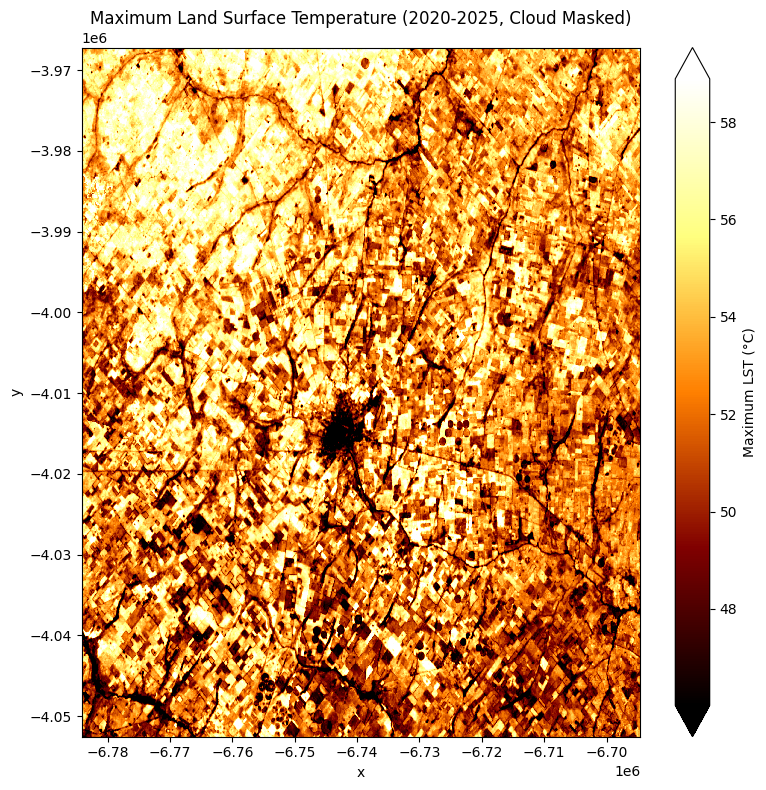

In [8]:
# Plot the result
fig, ax = plt.subplots(figsize=(8, 8))
LST_max_computed.plot.imshow(
    ax=ax,
    cmap="afmhot",
    cbar_kwargs={"label": "Maximum LST (°C)"},
    robust=True,  # Use 2nd and 98th percentiles for color scaling
)
ax.set_title("Maximum Land Surface Temperature (2020-2025, Cloud Masked)")
plt.tight_layout()
plt.show()

In [9]:
# Optional: Save to file
# LST_max_computed.rio.to_raster(RUTA_DATOS / "LST_max_5years.tif")

# Print some statistics
print("\nMaximum LST Statistics:")
print(f"  Overall max: {float(LST_max_computed.max().values):.2f}°C")
print(f"  Overall min: {float(LST_max_computed.min().values):.2f}°C")
print(f"  Mean of maximums: {float(LST_max_computed.mean().values):.2f}°C")
print(f"  Median of maximums: {float(LST_max_computed.median().values):.2f}°C")


Maximum LST Statistics:
  Overall max: 65.36°C
  Overall min: 33.75°C
  Mean of maximums: 52.91°C
  Median of maximums: 52.91°C


In [15]:
import cdsapi
import xarray as xr
import pandas as pd

c = cdsapi.Client()

# Get historical data
historical_file = "ipcc_atlas_historical.nc"
c.retrieve(
    "projections-climate-atlas",
    {
        "origin": "cmip6",
        "experiment": "historical",
        "domain": "global",
        "variable": "monthly_count_of_days_with_maximum_temperature_above_35_c",
        "format": "zip",
    },
    historical_file
)

2025-11-13 11:29:54,235 INFO Request ID is 8d15c4d8-d5f5-4a02-b2b5-2fcc68f6ef5a
2025-11-13 11:29:54,557 INFO status has been updated to accepted
2025-11-13 11:30:04,071 INFO status has been updated to running
2025-11-13 11:30:46,706 INFO status has been updated to successful


f598f1aa657e6575dc849da80b10f096.zip:   0%|          | 0.00/245M [00:00<?, ?B/s]

'ipcc_atlas_historical.nc'

In [13]:
import zipfile
import os

historical_file = "ipcc_atlas_historical.nc"

# Check if it's a zip file
with zipfile.ZipFile(historical_file, 'r') as zip_ref:
    print("Files in archive:")
    print(zip_ref.namelist())
    
    # Extract all
    zip_ref.extractall("ipcc_historical_data")

# Find the actual .nc file
nc_files = [f for f in os.listdir("ipcc_historical_data") if f.endswith('.nc')]
print(f"\nNetCDF files: {nc_files}")

# Open the actual NetCDF file
if nc_files:
    actual_nc_file = os.path.join("ipcc_historical_data", nc_files[0])
    ds = xr.open_dataset(actual_nc_file)
    print(ds)
    
    # Subset to Pergamino bbox
    bbox = bbox_pergamino_4326
    ds_subset = ds.sel(
        lon=slice(bbox[0], bbox[2]),
        lat=slice(bbox[1], bbox[3])
    )
    
    df = ds_subset.to_dataframe().reset_index()
    print(df.head())

Files in archive:
['provenance.json', 'provenance.png', 'tx35_CMIP6_historical_mon_185001-201412.nc']

NetCDF files: ['tx35_CMIP6_historical_mon_185001-201412.nc']
<xarray.Dataset> Size: 14GB
Dimensions:          (lat: 180, bnds: 2, lon: 360, time: 1980, member: 28)
Coordinates:
  * lat              (lat) float64 1kB -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * lon              (lon) float64 3kB -179.5 -178.5 -177.5 ... 178.5 179.5
  * time             (time) datetime64[ns] 16kB 1850-01-01 ... 2014-12-01
    member_id        (member) <U45 5kB ...
    gcm_institution  (member) <U19 2kB ...
    gcm_model        (member) <U16 2kB ...
    gcm_variant      (member) <U8 896B ...
    threshold        float32 4B ...
    height2m         float64 8B ...
Dimensions without coordinates: bnds, member
Data variables:
    lat_bnds         (lat, bnds) float64 3kB ...
    lon_bnds         (lon, bnds) float64 6kB ...
    time_bnds        (time, bnds) datetime64[ns] 32kB ...
    tx35             (member, tim

/home/nissim/Documents/dev/datos-escala-humana/.venv/lib/python3.12/site-packages/xarray/conventions.py:204: SerializationWarning: variable 'tx35' has multiple fill values {np.float32(1.0384594e+34), np.float32(-1.7014118e+38)} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


In [16]:
# Subset to Pergamino bbox using nearest neighbor selection
bbox = bbox_pergamino_4326  # [minx, miny, maxx, maxy]

# Select the grid cell(s) that overlap with your bbox
ds_subset = ds.sel(
    lon=slice(bbox[0], bbox[2]),
    lat=slice(bbox[1], bbox[3])
)

print(f"Subset shape: {ds_subset.dims}")

# If empty, use nearest point instead
if ds_subset.dims.get('lon', 0) == 0 or ds_subset.dims.get('lat', 0) == 0:
    print("Bbox too small for grid, using nearest point")
    center_lon = (bbox[0] + bbox[2]) / 2
    center_lat = (bbox[1] + bbox[3]) / 2
    
    ds_subset = ds.sel(lon=center_lon, lat=center_lat, method='nearest')

# Get the tx35 variable and take mean across ensemble members
tx35_mean = ds_subset['tx35'].mean(dim='member')

# Convert to dataframe
df = tx35_mean.to_dataframe().reset_index()
print(f"\nDataFrame shape: {df.shape}")
print(df.head(20))

# Group by year and sum monthly counts to get annual days > 35°C
df['year'] = df['time'].dt.year
annual_days = df.groupby('year')['tx35'].sum().reset_index()
annual_days.columns = ['year', 'days_over_35C']

print("\nAnnual days over 35°C:")
print(annual_days)

Subset shape: FrozenMappingWarningOnValuesAccess({'lat': 0, 'bnds': 2, 'lon': 1, 'time': 1980, 'member': 28})
Bbox too small for grid, using nearest point


/tmp/ipykernel_96249/377625514.py:13: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if ds_subset.dims.get('lon', 0) == 0 or ds_subset.dims.get('lat', 0) == 0:
<frozen _collections_abc>:807: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.



DataFrame shape: (1980, 6)
         time   lat   lon  threshold  height2m       tx35
0  1850-01-01 -33.5 -60.5       35.0       2.0  11.972936
1  1850-02-01 -33.5 -60.5       35.0       2.0   8.441825
2  1850-03-01 -33.5 -60.5       35.0       2.0   4.309710
3  1850-04-01 -33.5 -60.5       35.0       2.0   0.609305
4  1850-05-01 -33.5 -60.5       35.0       2.0   0.000000
5  1850-06-01 -33.5 -60.5       35.0       2.0   0.000000
6  1850-07-01 -33.5 -60.5       35.0       2.0   0.000000
7  1850-08-01 -33.5 -60.5       35.0       2.0   0.000000
8  1850-09-01 -33.5 -60.5       35.0       2.0   0.226702
9  1850-10-01 -33.5 -60.5       35.0       2.0   1.496477
10 1850-11-01 -33.5 -60.5       35.0       2.0   3.966239
11 1850-12-01 -33.5 -60.5       35.0       2.0   6.770822
12 1851-01-01 -33.5 -60.5       35.0       2.0  11.606445
13 1851-02-01 -33.5 -60.5       35.0       2.0   8.725586
14 1851-03-01 -33.5 -60.5       35.0       2.0   3.179025
15 1851-04-01 -33.5 -60.5       35.0       2

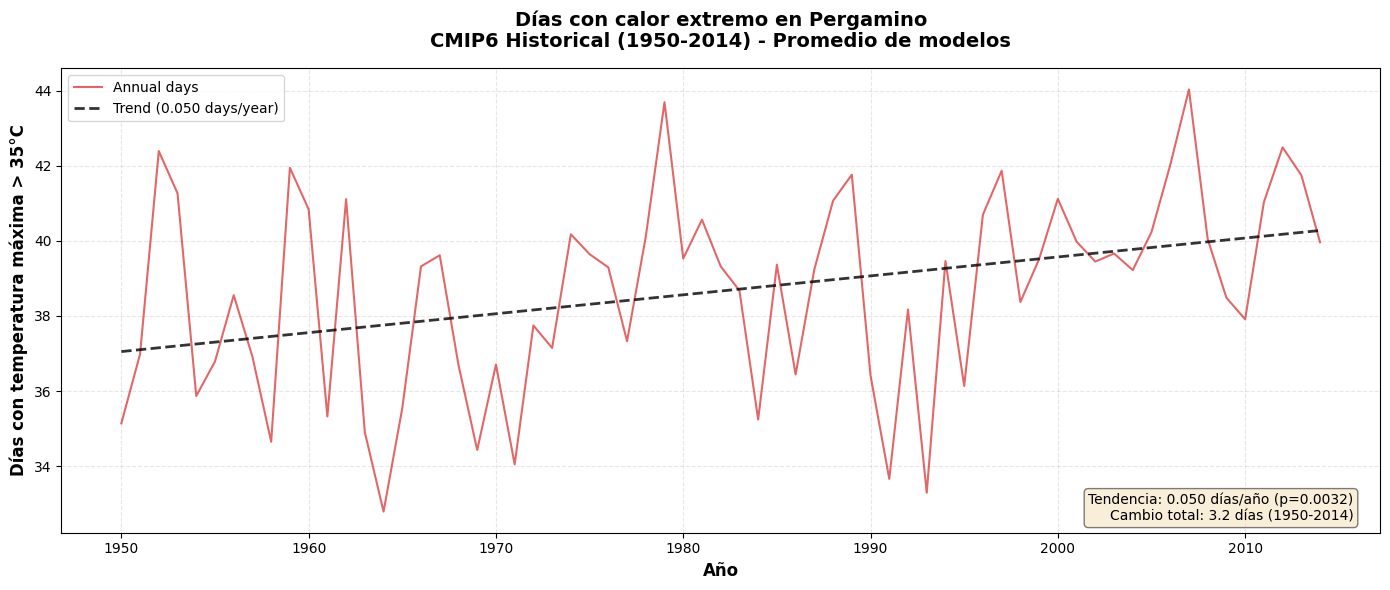


Resumen estadístico (1950-2014):
Promedio 1950-1979: 37.9 días/año
Promedio 1980-2014: 39.3 días/año
Tendencia: 0.050 días/año
Cambio total: 3.2 días (1950-2014)


In [18]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Filter to 1950 onwards
annual_days_1950 = annual_days[annual_days['year'] >= 1950].copy()

# Time series plot
fig, ax = plt.subplots(figsize=(14, 6))

# Plot the data
ax.plot(annual_days_1950['year'], annual_days_1950['days_over_35C'], 
        linewidth=1.5, color='#d62728', alpha=0.7, label='Annual days')

# Add trend line
z = np.polyfit(annual_days_1950['year'], annual_days_1950['days_over_35C'], 1)
p = np.poly1d(z)
ax.plot(annual_days_1950['year'], p(annual_days_1950['year']), 
        "--", linewidth=2, color='black', alpha=0.8, label=f'Trend ({z[0]:.3f} days/year)')

# Calculate statistics
slope, intercept, r_value, p_value, std_err = stats.linregress(
    annual_days_1950['year'], annual_days_1950['days_over_35C']
)
total_change = slope * (annual_days_1950['year'].max() - annual_days_1950['year'].min())

# Styling
ax.set_xlabel('Año', fontsize=12, fontweight='bold')
ax.set_ylabel('Días con temperatura máxima > 35°C', fontsize=12, fontweight='bold')
ax.set_title(
    f'Días con calor extremo en Pergamino\nCMIP6 Historical (1950-2014) - Promedio de modelos',
    fontsize=14, fontweight='bold', pad=15
)
ax.grid(alpha=0.3, linestyle='--')
ax.legend(loc='upper left', fontsize=10)

# Add statistics text
stats_text = f'Tendencia: {slope:.3f} días/año (p={p_value:.4f})\nCambio total: {total_change:.1f} días (1950-2014)'
ax.text(0.98, 0.02, stats_text, transform=ax.transAxes,
        fontsize=10, verticalalignment='bottom', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

# Summary statistics
print(f"\nResumen estadístico (1950-2014):")
print(f"Promedio 1950-1979: {annual_days_1950[annual_days_1950['year'] < 1980]['days_over_35C'].mean():.1f} días/año")
print(f"Promedio 1980-2014: {annual_days_1950[annual_days_1950['year'] >= 1980]['days_over_35C'].mean():.1f} días/año")
print(f"Tendencia: {slope:.3f} días/año")
print(f"Cambio total: {total_change:.1f} días (1950-2014)")

In [19]:
import cdsapi
import xarray as xr
import pandas as pd
import zipfile
import os
from pathlib import Path

# Define experiments to download
experiments = {
    'historical': {'experiment': 'historical', 'period': None},
    'ssp1_2_6': {'experiment': 'ssp1_2_6', 'period': '2015-2100'},
    'ssp2_4_5': {'experiment': 'ssp2_4_5', 'period': '2015-2100'},
    'ssp5_8_5': {'experiment': 'ssp5_8_5', 'period': '2015-2100'},
}

c = cdsapi.Client()
bbox = bbox_pergamino_4326
center_lon = (bbox[0] + bbox[2]) / 2
center_lat = (bbox[1] + bbox[3]) / 2

# Dictionary to store processed data
all_data = {}

for exp_name, exp_config in experiments.items():
    print(f"\nProcessing {exp_name}...")
    
    zip_file = f"ipcc_atlas_{exp_name}.zip"
    extract_dir = f"ipcc_{exp_name}_data"
    
    # Download if not exists
    if not Path(zip_file).exists():
        print(f"  Downloading {exp_name}...")
        request = {
            "origin": "cmip6",
            "experiment": exp_config['experiment'],
            "domain": "global",
            "variable": "monthly_count_of_days_with_maximum_temperature_above_35_c",
        }
        if exp_config['period']:
            request['period'] = exp_config['period']
        
        c.retrieve("projections-climate-atlas", request, zip_file)
    else:
        print(f"  File exists, skipping download")
    
    # Extract and process
    if not Path(extract_dir).exists():
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)
    
    nc_files = [f for f in os.listdir(extract_dir) if f.endswith('.nc')]
    actual_nc_file = os.path.join(extract_dir, nc_files[0])
    
    # Load and subset
    ds = xr.open_dataset(actual_nc_file)
    ds_subset = ds.sel(lon=center_lon, lat=center_lat, method='nearest')
    tx35_mean = ds_subset['tx35'].mean(dim='member')
    
    # Convert to annual data
    df = tx35_mean.to_dataframe().reset_index()
    df['year'] = df['time'].dt.year
    annual_days = df.groupby('year')['tx35'].sum().reset_index()
    annual_days.columns = ['year', 'days_over_35C']
    
    all_data[exp_name] = annual_days
    print(f"  Processed {len(annual_days)} years: {annual_days['year'].min()}-{annual_days['year'].max()}")

print("\nAll data loaded:")
for exp_name, data in all_data.items():
    print(f"  {exp_name}: {len(data)} years")


Processing historical...


2025-11-13 11:40:33,923 INFO Request ID is bd712fc2-bcdb-44e4-95ae-e5329c1ed872
2025-11-13 11:40:34,255 INFO status has been updated to accepted
2025-11-13 11:40:40,256 INFO status has been updated to running
2025-11-13 11:41:26,443 INFO status has been updated to successful


f265268728722f78bac79c283b75dbc6.zip:   0%|          | 0.00/245M [00:00<?, ?B/s]

/home/nissim/Documents/dev/datos-escala-humana/.venv/lib/python3.12/site-packages/xarray/conventions.py:204: SerializationWarning: variable 'tx35' has multiple fill values {np.float32(1.0384594e+34), np.float32(-1.7014118e+38)} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


  Processed 165 years: 1850-2014

Processing ssp1_2_6...


2025-11-13 11:41:59,845 INFO Request ID is c9ddbacb-9187-4089-ac40-6a03b36bcb8e
2025-11-13 11:42:00,230 INFO status has been updated to accepted
2025-11-13 11:42:06,099 INFO status has been updated to running
2025-11-13 11:42:52,468 INFO status has been updated to successful


93aaf1b87d1978cdef984d08687d7339.zip:   0%|          | 0.00/211M [00:00<?, ?B/s]

/home/nissim/Documents/dev/datos-escala-humana/.venv/lib/python3.12/site-packages/xarray/conventions.py:204: SerializationWarning: variable 'tx35' has multiple fill values {np.float32(1.0384594e+34), np.float32(-1.7014118e+38)} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


  Processed 86 years: 2015-2100

Processing ssp2_4_5...


2025-11-13 11:43:20,110 INFO Request ID is f2ae5a35-8fff-43c2-8d6f-45aa05e47341
2025-11-13 11:43:20,434 INFO status has been updated to accepted
2025-11-13 11:43:30,066 INFO status has been updated to running
2025-11-13 11:44:38,502 INFO status has been updated to successful


811bb496016faf0c0a19b3704702c514.zip:   0%|          | 0.00/223M [00:00<?, ?B/s]

/home/nissim/Documents/dev/datos-escala-humana/.venv/lib/python3.12/site-packages/xarray/conventions.py:204: SerializationWarning: variable 'tx35' has multiple fill values {np.float32(1.0384594e+34), np.float32(-1.7014118e+38)} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


  Processed 86 years: 2015-2100

Processing ssp5_8_5...


2025-11-13 11:45:06,443 INFO Request ID is cf6034e7-f2cf-411e-b5e3-ab2498e2423d
2025-11-13 11:45:06,754 INFO status has been updated to accepted
2025-11-13 11:45:16,168 INFO status has been updated to running
2025-11-13 11:45:58,723 INFO status has been updated to successful


a784d0654979055f5aad9db4b8ccfd1c.zip:   0%|          | 0.00/249M [00:00<?, ?B/s]

/home/nissim/Documents/dev/datos-escala-humana/.venv/lib/python3.12/site-packages/xarray/conventions.py:204: SerializationWarning: variable 'tx35' has multiple fill values {np.float32(1.0384594e+34), np.float32(-1.7014118e+38)} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


  Processed 86 years: 2015-2100

All data loaded:
  historical: 165 years
  ssp1_2_6: 86 years
  ssp2_4_5: 86 years
  ssp5_8_5: 86 years


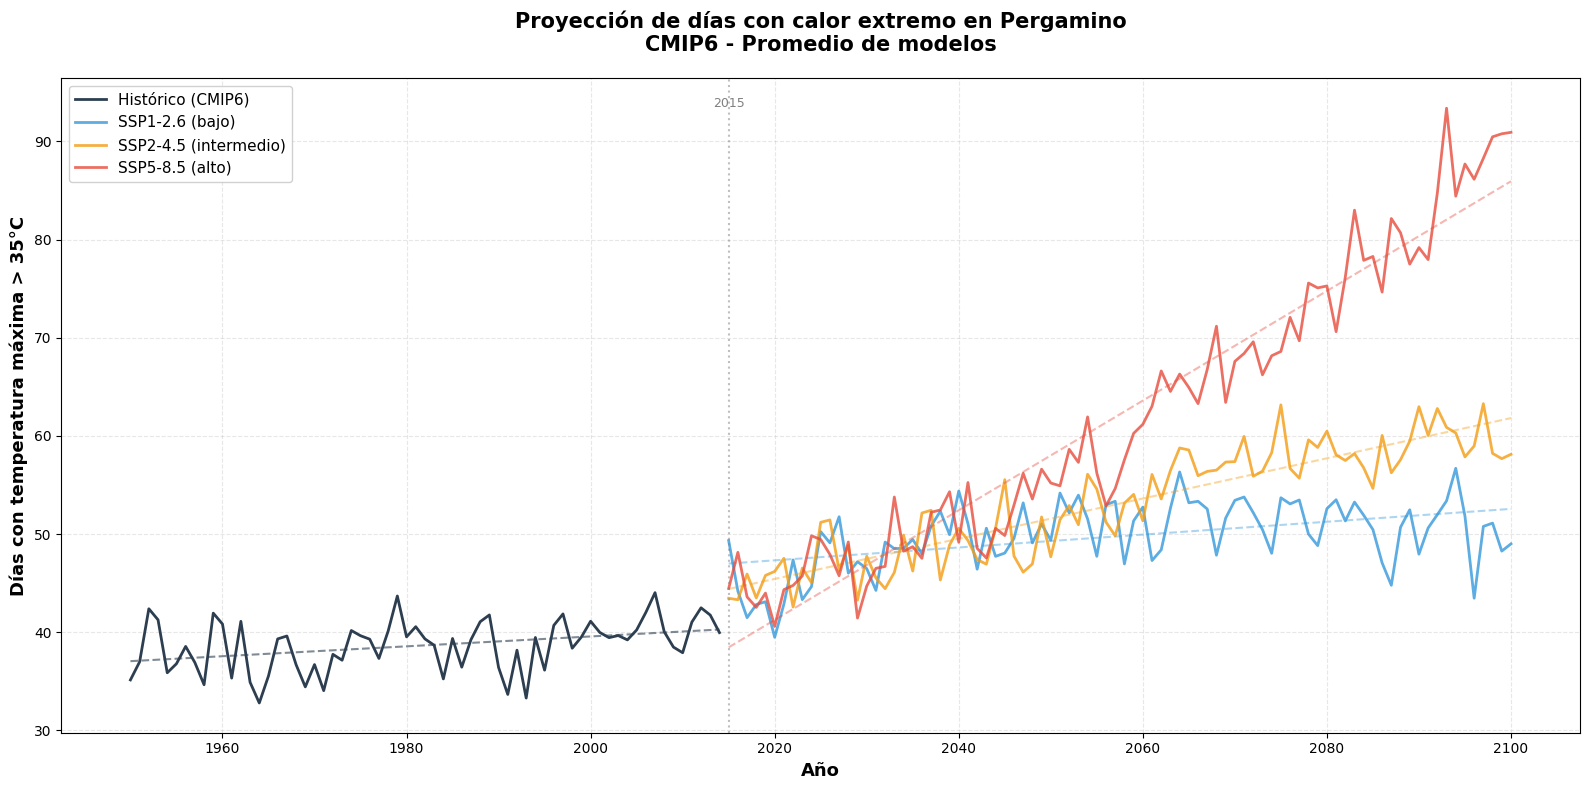


Estadísticas por período:

Histórico (1950-2014): 38.7 días/año
  Tendencia: 0.050 días/año

SSP1-2.6 (bajo):
  2015-2050: 47.8 días/año
  2051-2100: 51.2 días/año
  Tendencia: 0.065 días/año
  Último año (2100): 49.0 días/año

SSP2-4.5 (intermedio):
  2015-2050: 47.5 días/año
  2051-2100: 57.1 días/año
  Tendencia: 0.205 días/año
  Último año (2100): 58.1 días/año

SSP5-8.5 (alto):
  2015-2050: 48.7 días/año
  2051-2100: 71.9 días/año
  Tendencia: 0.559 días/año
  Último año (2100): 90.9 días/año



In [20]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Filter historical to 1950+
historical_1950 = all_data['historical'][all_data['historical']['year'] >= 1950].copy()

# Create plot
fig, ax = plt.subplots(figsize=(16, 8))

# Define colors for scenarios
colors = {
    'historical': '#2c3e50',
    'ssp1_2_6': '#3498db',  # Blue - low emissions
    'ssp2_4_5': '#f39c12',  # Orange - middle
    'ssp5_8_5': '#e74c3c',  # Red - high emissions
}

labels = {
    'historical': 'Histórico (CMIP6)',
    'ssp1_2_6': 'SSP1-2.6 (bajo)',
    'ssp2_4_5': 'SSP2-4.5 (intermedio)',
    'ssp5_8_5': 'SSP5-8.5 (alto)',
}

# Plot historical
ax.plot(historical_1950['year'], historical_1950['days_over_35C'], 
        linewidth=2, color=colors['historical'], label=labels['historical'])

# Add historical trend line
z_hist = np.polyfit(historical_1950['year'], historical_1950['days_over_35C'], 1)
p_hist = np.poly1d(z_hist)
ax.plot(historical_1950['year'], p_hist(historical_1950['year']), 
        "--", linewidth=1.5, color=colors['historical'], alpha=0.6)

# Plot projections
for scenario in ['ssp1_2_6', 'ssp2_4_5', 'ssp5_8_5']:
    data = all_data[scenario]
    ax.plot(data['year'], data['days_over_35C'], 
            linewidth=2, color=colors[scenario], label=labels[scenario], alpha=0.8)
    
    # Add trend line for each scenario
    z = np.polyfit(data['year'], data['days_over_35C'], 1)
    p = np.poly1d(z)
    ax.plot(data['year'], p(data['year']), 
            "--", linewidth=1.5, color=colors[scenario], alpha=0.4)

# Styling
ax.set_xlabel('Año', fontsize=13, fontweight='bold')
ax.set_ylabel('Días con temperatura máxima > 35°C', fontsize=13, fontweight='bold')
ax.set_title('Proyección de días con calor extremo en Pergamino\nCMIP6 - Promedio de modelos', 
             fontsize=15, fontweight='bold', pad=20)
ax.grid(alpha=0.3, linestyle='--')
ax.legend(loc='upper left', fontsize=11, framealpha=0.9)

# Add vertical line at 2015 to mark transition
ax.axvline(x=2015, color='gray', linestyle=':', linewidth=1.5, alpha=0.5)
ax.text(2015, ax.get_ylim()[1] * 0.98, '2015', 
        ha='center', va='top', fontsize=9, color='gray')

plt.tight_layout()
plt.show()

# Print statistics
print("\nEstadísticas por período:\n")
print(f"Histórico (1950-2014): {historical_1950['days_over_35C'].mean():.1f} días/año")
print(f"  Tendencia: {z_hist[0]:.3f} días/año\n")

for scenario in ['ssp1_2_6', 'ssp2_4_5', 'ssp5_8_5']:
    data = all_data[scenario]
    slope = np.polyfit(data['year'], data['days_over_35C'], 1)[0]
    print(f"{labels[scenario]}:")
    print(f"  2015-2050: {data[data['year'] <= 2050]['days_over_35C'].mean():.1f} días/año")
    print(f"  2051-2100: {data[data['year'] > 2050]['days_over_35C'].mean():.1f} días/año")
    print(f"  Tendencia: {slope:.3f} días/año")
    print(f"  Último año (2100): {data[data['year'] == 2100]['days_over_35C'].values[0]:.1f} días/año\n")

In [22]:
# Calculate historical baseline (1950-2014)
hist_baseline = all_data['historical'][all_data['historical']['year'] >= 1950]['days_over_35C'].mean()

print(f"Histórico (1950-2014): {hist_baseline:.1f} días/año\n")

# Calculate % increase for near-term (2020-2050)
for scenario in ['ssp1_2_6', 'ssp2_4_5', 'ssp5_8_5']:
    near_term = all_data[scenario][(all_data[scenario]['year'] >= 2020) & 
                                    (all_data[scenario]['year'] <= 2050)]
    near_avg = near_term['days_over_35C'].mean()
    pct_increase = ((near_avg - hist_baseline) / hist_baseline) * 100
    
    print(f"{labels[scenario]} (2020-2050):")
    print(f"  Promedio: {near_avg:.1f} días/año")
    print(f"  Aumento: +{near_avg - hist_baseline:.1f} días ({pct_increase:+.1f}%)\n")

Histórico (1950-2014): 38.7 días/año

SSP1-2.6 (bajo) (2020-2050):
  Promedio: 48.4 días/año
  Aumento: +9.7 días (+25.1%)

SSP2-4.5 (intermedio) (2020-2050):
  Promedio: 48.0 días/año
  Aumento: +9.3 días (+24.2%)

SSP5-8.5 (alto) (2020-2050):
  Promedio: 49.3 días/año
  Aumento: +10.7 días (+27.6%)



In [21]:
# Calculate historical baseline (1950-2014)
hist_baseline = all_data['historical'][all_data['historical']['year'] >= 1950]['days_over_35C'].mean()

print(f"Histórico (1950-2014): {hist_baseline:.1f} días/año\n")

# Calculate % increase for each scenario
for scenario in ['ssp1_2_6', 'ssp2_4_5', 'ssp5_8_5']:
    # End of century (2070-2100)
    eoc_avg = all_data[scenario][all_data[scenario]['year'] >= 2070]['days_over_35C'].mean()
    pct_increase = ((eoc_avg - hist_baseline) / hist_baseline) * 100
    
    print(f"{labels[scenario]} (2070-2100):")
    print(f"  Promedio: {eoc_avg:.1f} días/año")
    print(f"  Aumento: +{eoc_avg - hist_baseline:.1f} días ({pct_increase:+.1f}%)\n")

Histórico (1950-2014): 38.7 días/año

SSP1-2.6 (bajo) (2070-2100):
  Promedio: 51.0 días/año
  Aumento: +12.3 días (+31.8%)

SSP2-4.5 (intermedio) (2070-2100):
  Promedio: 58.8 días/año
  Aumento: +20.1 días (+52.0%)

SSP5-8.5 (alto) (2070-2100):
  Promedio: 78.4 días/año
  Aumento: +39.8 días (+102.8%)



In [19]:
# Connect to Planetary Computer
copernicus_catalog = pystac_client.Client.open(
    "https://cds.climate.copernicus.eu/api/catalogue/v1/",
)


In [22]:
collection = copernicus_catalog.get_collection("derived-era5-single-levels-daily-statistics")


In [23]:
collection

<CollectionClient id=derived-era5-single-levels-daily-statistics>

In [ ]:
# Get all items from the collection
items = list(ccollection.get_items())

NameError: name 'collection' is not defined

In [26]:
## era 5 data

# Get the collection
collection = copernicus_catalog.get_collection("derived-era5-single-levels-daily-statistics")

# Inspect available links
print("Available links:")
for link in collection.links:
    print(f"  rel: {link.rel}, href: {link.href}, title: {link.title if hasattr(link, 'title') else 'N/A'}")

Available links:
  rel: self, href: https://cds.climate.copernicus.eu/api/catalogue/v1/collections/derived-era5-single-levels-daily-statistics, title: None
  rel: parent, href: https://cds.climate.copernicus.eu/api/catalogue/v1/, title: None
  rel: root, href: https://cds.climate.copernicus.eu/api/catalogue/v1/, title: ECMWF Data Stores STAC Catalogue API
  rel: license, href: https://spdx.org/licenses/CC-BY-4.0, title: CC-BY licence
  rel: form, href: https://object-store.os-api.cci2.ecmwf.int:443/cci2-prod-catalogue/resources/derived-era5-single-levels-daily-statistics/form_1170d0ad725069255790da261c2a87bc264b5a3417aa32c277ecf7eacfb96bf6.json, title: None
  rel: constraints, href: https://object-store.os-api.cci2.ecmwf.int:443/cci2-prod-catalogue/resources/derived-era5-single-levels-daily-statistics/constraints_f0e9d71d2f8c85a0d7e0e98fa2a8eb8469afa693a9ca7b0c9f07669a7139909d.json, title: None
  rel: retrieve, href: https://cds.climate.copernicus.eu/api/retrieve/v1/processes/derived-e

In [27]:
## era 5 data

import requests
import json

# Get the form to see available parameters
form_url = "https://object-store.os-api.cci2.ecmwf.int:443/cci2-prod-catalogue/resources/derived-era5-single-levels-daily-statistics/form_1170d0ad725069255790da261c2a87bc264b5a3417aa32c277ecf7eacfb96bf6.json"
form_response = requests.get(form_url)
form_data = form_response.json()

# Pretty print to see structure
print(json.dumps(form_data, indent=2))

[
  {
    "name": "product_type",
    "label": "Product type",
    "help": null,
    "required": true,
    "css": "todo",
    "type": "StringChoiceWidget",
    "details": {
      "values": [
        "reanalysis",
        "ensemble_members",
        "ensemble_mean"
      ],
      "columns": 6,
      "labels": {
        "reanalysis": "Reanalysis",
        "ensemble_members": "Ensemble members",
        "ensemble_mean": "Ensemble mean"
      },
      "default": [
        "reanalysis"
      ]
    },
    "id": "product_type"
  },
  {
    "name": "variable",
    "label": "Variable",
    "help": "Please, consult the product user guide in the documentation section for more information on these variables.",
    "required": true,
    "css": "todo",
    "type": "StringListArrayWidget",
    "details": {
      "groups": [
        {
          "label": "Popular",
          "open": true,
          "values": [
            "10m_u_component_of_wind",
            "10m_v_component_of_wind",
            "2m

In [20]:
## era 5 data


# Query for last 5 years
bbox = bbox_pergamino_4326
datetime = "2020-01-01/2025-01-01"  # Last 5 years

query = copernicus_catalog.search(
    collections=["derived-era5-single-levels-daily-statistics"],
    bbox=bbox,
    datetime=datetime,
)

items = list(query.items())
print(f"Found: {len(items):d} datasets")


# derived-era5-single-levels-daily-statistics

DoesNotConformTo: Server does not conform to ITEM_SEARCH, There is no fallback option available for search.

In [ ]:
# Load the cloud GeoTIFF clipped to your GeoDataFrame
suelo_2022_ruta = "https://storage.googleapis.com/mapbiomas-public/initiatives/argentina/collection-1/coverage/argentina_coverage_2022.tif"

# 1. Use your existing Dask cluster for parallel reads
suelo_2022 = rio.open_rasterio(
    suelo_2022_ruta,
    chunks={"x": 2048, "y": 2048},  # Larger chunks = fewer tasks, faster
    lock=False,  # Critical: allows parallel HTTP reads from GCS
)

# For the clip/compute operation
with ProgressBar():
    # 2. Clip efficiently
    suelo_2022 = suelo_2022.rio.clip(
        pergamino.geometry.values,
        pergamino.crs,
        from_disk=True,
        all_touched=False,  # Only pixels with centers inside
    )

In [ ]:
# Define the detailed categories and colors
categories_detailed = {
    "Leñosa cerrada": {"ids": [3], "color": "#1f8d49"},
    "Leñosa abierta": {"ids": [4], "color": "#7dc975"},
    "Leñosa dispersa": {"ids": [45], "color": "#807a40"},
    "Leñosa inundable": {"ids": [6], "color": "#026975"},
    "Vegetación no leñosa inundable": {"ids": [11], "color": "#519799"},
    "Pastizal": {"ids": [12], "color": "#d6bc74"},
    "Estepa": {"ids": [63], "color": "#ebf8b5"},
    "Pastura": {"ids": [15], "color": "#edde8e"},
    "Agricultura": {"ids": [18], "color": "#e974ed"},
    "Plantación forestal": {"ids": [9], "color": "#7a5900"},
    "Cultivo arbustivo": {"ids": [36], "color": "#d082de"},
    "Mosaico agropecuario": {"ids": [21], "color": "#ffefc3"},
    "Área sin vegetación": {"ids": [22], "color": "#d4271e"},
    "Río, lago u océano": {"ids": [33], "color": "#2532e4"},
    "Hielo y nieve en superficie": {"ids": [34], "color": "#93dfe6"},
    "No observado": {"ids": [27], "color": "#ffffff"},
}

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Create colormap from detailed categories
colors = {}
for category, info in categories_detailed.items():
    for pixel_id in info["ids"]:
        colors[pixel_id] = info["color"]

cmap = mcolors.ListedColormap([colors[i] for i in sorted(colors.keys())])
bounds = sorted(colors.keys())
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Plot
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the raster
im = suelo_2022.plot(ax=ax, cmap=cmap, norm=norm, add_colorbar=False)

# Create custom legend from detailed categories
legend_labels = {}
for category, info in categories_detailed.items():
    legend_labels[info["color"]] = category

# Add legend below the map
legend_elements = [
    plt.Rectangle((0, 0), 1, 1, facecolor=color, label=label)
    for color, label in legend_labels.items()
]
ax.legend(
    handles=legend_elements,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.1),
    ncol=3,
    frameon=False,
)

plt.title("Cobertura del Suelo - MapBiomas 2022")
plt.tight_layout()
plt.show()

In [ ]:
# 1. Reproject land cover to match LST grid (if needed)
suelo_aligned = suelo_2022.rio.reproject_match(LST_max_computed)

# 2. Flatten both arrays and create DataFrame
lst_flat = LST_max_computed.values.flatten()
landcover_flat = suelo_aligned.values.flatten()

df = pd.DataFrame({"LST": lst_flat, "LandCover": landcover_flat})

# 3. Filter out invalid values
df_clean = df[
    (df["LandCover"] > 0)  # Remove 0
    & (df["LandCover"] < 255)  # Remove 255
    & (~df["LandCover"].isna())  # Remove NaN
    & (~df["LST"].isna())  # Remove LST NaN
].copy()

In [ ]:
# Create mapping from IDs to category names
id_to_name = {}
for category, details in categories_detailed.items():
    for id_val in details["ids"]:
        id_to_name[id_val] = category

# Add readable names to dataframe
df_clean["Category"] = df_clean["LandCover"].astype(int).map(id_to_name)

# Sort by median LST for better visualization
category_order = (
    df_clean.groupby("Category")["LST"].median().sort_values(ascending=False).index
)

# Box plot with sorted categories
fig, ax = plt.subplots(figsize=(14, 8))
df_clean.boxplot(
    column="LST",
    by="Category",
    ax=ax,
    showfliers=False,  # Hide outliers for cleaner view
    positions=range(len(category_order)),
    patch_artist=True,  # Allows coloring boxes
)

# Set x-axis with sorted order
ax.set_xticklabels(category_order, rotation=45, ha="right")
ax.set_xlabel("Categoría de Cobertura del Suelo", fontsize=12)
ax.set_ylabel("LST Máxima (°C)", fontsize=12)
ax.set_title(
    "Distribución de Temperatura Superficial por Cobertura del Suelo\n(Máximo 2020-2025, Pergamino)",
    fontsize=14,
    pad=20,
)
ax.grid(axis="y", alpha=0.3)
plt.suptitle("")  # Remove default pandas title
plt.tight_layout()
plt.show()

In [ ]:
# Summary statistics with Spanish names
summary = (
    df_clean.groupby("Category")["LST"]
    .agg(
        [
            ("Píxeles", "count"),
            ("Media", "mean"),
            ("Mediana", "median"),
            ("Desv. Est.", "std"),
            ("Mín", "min"),
            ("Máx", "max"),
        ]
    )
    .round(2)
    .sort_values("Mediana", ascending=False)
)

print("\nEstadísticas de LST por Categoría:")
summary

## Populated areas:
- Map populated areas

Question: is it worth including summary stats of population, buildings per populated area? Or is that unnecessary? Maybe it's something that I jsut *gesture* at--indicate in teh comments that one _could_ do it, but we will not because it's out of scope. But link to how to do it.

- Descriptive stats--more distributions of heat per area. WHich ones are hottest on average? (It'll be urban and peri-urban)

## Periurban areas

### EDA
- Plot distribution
- Classify quartiles
- Map hotspots (top 25%)
- Zoom in particularly on industrial parks, for example
- Assess by land cover type (tukey, etc)
- Assess by tree canopy cover (correlation? box plots? this might involve some log transformations to make it intelligible)
- Assess by built volume
- Assess by distance to water

### Modeling
- Build model including neighborhood factors
- Model + interpret. Include spatial cross-validation, SHAP assessment.
     - How reproducible is this? I wonder...
- Explain in clear langauge what it means for policy implications.

## Urban core

### EDA
- Plot distribution
- Classify quartiles
- Map hotspots (top 25%)
- Zoom in particularly on industrial parks, for example
- Assess by land cover type (tukey, etc)
- Assess by tree canopy cover (correlation? box plots? this might involve some log transformations to make it intelligible)
- Assess by built volume
- Assess by distance to water

### Modeling
- Build model including neighborhood factors
- Model + interpret. Include spatial cross-validation, SHAP assessment.
     - How reproducible is this? I wonder...
- Explain in clear langauge what it means for policy implications.

## Recommendations
- Draw neavily from WRI material
- Split for periurban versus urban areas (what's feasible, desirable)

In [ ]:
import planetary_computer
import pystac_client
import matplotlib.pyplot as plt
from dask.distributed import Client, LocalCluster
from odc.stac import configure_rio, stac_load

import geopandas as gpd

from pathlib import Path
from matplotlib import colors

import matplotlib.pyplot as plt


import geopandas as gpd
import pandas as pd
from dask.diagnostics import ProgressBar
import rioxarray as rio


USE_CRS = "EPSG:5347"
CRS_WGS84 = "EPSG:4326"

RUTA_BASE = Path("/home/nissim/Documents/dev/datos-escala-humana/")
RUTA_DATOS = RUTA_BASE / "data"

So the first thing we're going to do is simply load our municipal boundaries from the Instituto Geográfico Nacional, their open data portal as a web feature service, so we'll download those or we'll load those directly and save them as a local GeoJSON file um.
And we're going to take their bounding box which we're going to use for our spatial queries um for uh.
And we're going to use a lot of data reads.

In [ ]:
def wfs_to_gdf(
    wfs_url: str, layer_name: str, srs: str = "EPSG:4326"
) -> gpd.GeoDataFrame:
    """
    Descarga una capa WFS y la devuelve como GeoDataFrame.

    Args:
        wfs_url (str): URL del servicio WFS.
        layer_name (str): Nombre de la capa (typename).
        srs (str): Código EPSG del sistema de referencia de coordenadas.

    Returns:
        gpd.GeoDataFrame: Capa descargada como GeoDataFrame.
    """
    wfs = WebFeatureService(url=wfs_url, version="2.0.0")
    response = wfs.getfeature(typename=layer_name, srsname=srs)
    gdf = gpd.read_file(BytesIO(response.read()))
    return gdf

In [ ]:
base_url = "https://wms.ign.gob.ar/geoserver/ign/ows"

if (RUTA_DATOS / "municipios.geojson").exists():
    munis = gpd.read_file(RUTA_DATOS / "municipios.geojson")
else:
    munis = wfs_to_gdf(wfs_url=base_url, layer_name="ign:municipio", srs="EPSG:4326")

pergamino = munis[munis["nam"] == "Pergamino"]
pergamino = pergamino.to_crs(USE_CRS)

bbox_pergamino_4326 = pergamino.to_crs(CRS_WGS84).total_bounds

The next thing we're going to do is use the pystack client library to connect the microsoft planetary computer microsoft planetary computer has uh hosts a lot of uh open satellite data and in this case we're going to use it to get landsat data which is a united states geological service satellite um which uh we're going to use the thermal band from um from um that satellite to um to pull in our uh land surface temperature data um so we'll connect to that satellite and we're going to set up um we're going to use dask actually to set up a local cluster for parallel processing um we're going to be using um a number of different workers to efficiently download these data.
So we'll set up a cluster that takes advantage of the multiple cores on our computer to be able to run in parallel uh efficiently and more efficiently process uh the data that we're working with.

In [ ]:
# Connect to Planetary Computer
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [ ]:
cluster = LocalCluster(
    processes=True,  # Critical: use processes, not threads
    n_workers=8,  # Use half your cores for workers
    threads_per_worker=2,  # 2 threads per worker = 16 total
    memory_limit="6GB",  # 8 workers × 6GB = 48GB, leaves headroom
)
client = Client(cluster)
print(f"Dask dashboard: {client.dashboard_link}")
configure_rio(cloud_defaults=True, client=client)

Next up we're going to pass a query to pystack client we're going to search through the landsat catalog using our area of interest for a date range from the beginning of 2020 through the beginning of 2025 so we're going to look through a five-year date range 2020 2021 2022 2023 2024 we're going to filter out areas with cloud cover um and we're going to process all these data sets now there are a lot of these data sets so this is which is why we're going to be using dask and what we're going to do is um process them um to uh calculate land surface temperature um and calculate the max land surface temperature per pixel in the last five years so the value of the pixel will be the max land surface temperature value of that pixel in the last five years.

In [ ]:
# Query for last 5 years
bbox = bbox_pergamino_4326
datetime = "2020-01-01/2025-01-01"  # Last 5 years
cloudy_less_than = 20  # You might need to be less strict for 5 years of data

query = catalog.search(
    collections=["landsat-c2-l2"],
    bbox=bbox,
    datetime=datetime,
    query={"eo:cloud_cover": {"lt": cloudy_less_than}},
)

items = list(query.items())
print(f"Found: {len(items):d} datasets")

In [ ]:
# Define output file path (same directory as notebook)
import os

notebook_dir = Path(os.path.dirname(os.path.abspath("pergamino.ipynb")))
lst_tif_path = notebook_dir / "LST_max_pergamino.tif"

# Check if file exists, otherwise compute
if lst_tif_path.exists():
    print(f"Loading existing LST data from {lst_tif_path}")
    LST_max_computed = rio.open_rasterio(lst_tif_path)
    # Squeeze out any extra dimensions if needed
    if len(LST_max_computed.dims) > 2:
        LST_max_computed = LST_max_computed.squeeze()
else:
    print("Computing LST from scratch...")
    # Load only thermal band and QA band
    crs = "epsg:3857"
    yy = stac_load(
        items,
        bands=("lwir11", "qa_pixel"),
        crs=crs,
        resolution=30,
        chunks={"time": 10},  # Process in chunks of 10 time steps
        groupby="landsat:scene_id",
        bbox=bbox_pergamino_4326,
    )

    # Create cloud mask function
    def create_cloud_mask(qa_band):
        """Mask clouds and cloud shadows"""
        # Bit 3: Cloud, Bit 4: Cloud Shadow
        cloud_mask = (qa_band & 0b11000) == 0
        return cloud_mask

    # Apply cloud mask
    yy_masked = yy.where(create_cloud_mask(yy.qa_pixel))

    # Convert thermal band to LST in Celsius
    LST_kelvin = yy_masked["lwir11"] * 0.00341802 + 149.0
    LST_celsius = LST_kelvin - 273.15

    # Calculate maximum LST per pixel over all time steps
    LST_max = LST_celsius.max(dim="time")

    # Before compute()
    print("Computing maximum LST...")
    print(f"Dashboard: {client.dashboard_link}")
    with ProgressBar():
        LST_max_computed = LST_max.compute()

    # Save to file
    print(f"Saving LST data to {lst_tif_path}")
    LST_max_computed.rio.to_raster(lst_tif_path)

Once we've done that we're going to um plot these data and we're going to see something interesting which is something that reflects land surface temperature and how it operates one land surface temperature these values are going to look insanely high um and they are because land surface temperature is the temperature of the ground itself which can be a lot hotter than the air um can absorb heat a lot and is is not connected to the temperature that we feel i mean it's not directly connected to the temperature we feel objectively to um to evaluate um.
The temperature that people experience we should be using things like universal thermal comfort or mean radiant temperature which are much better indicators of how people feel temperature but those are much more complicated to calculate so one of the approaches that we're taking here is to simply um is to to calculate these things in a way that's like less precise but is still reflective of how hot things are um and still gives us an idea of where we need to focus our energy and that's one of the major sort of theses of this project that we can actually have a lot of value with um available data sets rather than holding out for perfect data sets we can still generate a lot of really useful information for decision makers with data sets maybe not ideal but are good enough to inform the decision we want to make in this case land surface temperature is one of these things.
So we'll calculate land surface temperature here and then we'll calculate some quick summary statistics to just get a sense of what the distribution is and we'll see based on it of course that the distribution is not uh returns temperature values that are not that are very high in many cases right um but these are not air temperature these are land surface temperature.

In [ ]:
# Plot the result
fig, ax = plt.subplots(figsize=(16, 16))
LST_max_computed.plot.imshow(
    ax=ax,
    cmap="afmhot",
    cbar_kwargs={"label": "Maximum LST (°C)"},
    robust=True,  # Use 2nd and 98th percentiles for color scaling
)
ax.set_title("Maximum Land Surface Temperature (2020-2025, Cloud Masked)")
plt.tight_layout()
plt.show()

In [ ]:
# Optional: Save to file
# LST_max_computed.rio.to_raster(RUTA_DATOS / "LST_max_5years.tif")

# Print some statistics
print("\nMaximum LST Statistics:")
print(f"  Overall max: {float(LST_max_computed.max().values):.2f}°C")
print(f"  Overall min: {float(LST_max_computed.min().values):.2f}°C")
print(f"  Mean of maximums: {float(LST_max_computed.mean().values):.2f}°C")
print(f"  Median of maximums: {float(LST_max_computed.median().values):.2f}°C")

## Cobertura del suelo

Next we're going to load um land cover data for all of argentina from biomass um these are 2022 which is the most recent available year obviously 2025 data would be ideal but those aren't out yet um we're going to load these they're 30 meter resolution derived from actually landsat which is perfect because that'll make it really easy to align them with our our other landsat our heat data we're going to import these also using gas for efficiency's sake um we're going to quickly map them so we can see them uh with the color um that sort of has been given to us from the map biomass website and we'll just take a look at them across the province um and as you can see you know the areas that are showing up as hottest on our map are actually um a lot of the agricultural areas um and the natural areas and the urban areas are slightly cooler um.

In [ ]:
# Load the cloud GeoTIFF clipped to your GeoDataFrame
suelo_2022_ruta = "https://storage.googleapis.com/mapbiomas-public/initiatives/argentina/collection-1/coverage/argentina_coverage_2022.tif"

# 1. Use your existing Dask cluster for parallel reads
suelo_2022 = rio.open_rasterio(
    suelo_2022_ruta,
    chunks={"x": 2048, "y": 2048},  # Larger chunks = fewer tasks, faster
    lock=False,  # Critical: allows parallel HTTP reads from GCS
)

# For the clip/compute operation
with ProgressBar():
    # 2. Clip efficiently
    suelo_2022 = suelo_2022.rio.clip(
        pergamino.geometry.values,
        pergamino.crs,
        from_disk=True,
        all_touched=False,  # Only pixels with centers inside
    )

In [ ]:
# Define the detailed categories and colors
categories_detailed = {
    "Leñosa cerrada": {"ids": [3], "color": "#1f8d49"},
    "Leñosa abierta": {"ids": [4], "color": "#7dc975"},
    "Leñosa dispersa": {"ids": [45], "color": "#807a40"},
    "Leñosa inundable": {"ids": [6], "color": "#026975"},
    "Vegetación no leñosa inundable": {"ids": [11], "color": "#519799"},
    "Pastizal": {"ids": [12], "color": "#d6bc74"},
    "Estepa": {"ids": [63], "color": "#ebf8b5"},
    "Pastura": {"ids": [15], "color": "#edde8e"},
    "Agricultura": {"ids": [18], "color": "#e974ed"},
    "Plantación forestal": {"ids": [9], "color": "#7a5900"},
    "Cultivo arbustivo": {"ids": [36], "color": "#d082de"},
    "Mosaico agropecuario": {"ids": [21], "color": "#ffefc3"},
    "Área sin vegetación": {"ids": [22], "color": "#d4271e"},
    "Río, lago u océano": {"ids": [33], "color": "#2532e4"},
    "Hielo y nieve en superficie": {"ids": [34], "color": "#93dfe6"},
    "No observado": {"ids": [27], "color": "#ffffff"},
}

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Create colormap from detailed categories
colors = {}
for category, info in categories_detailed.items():
    for pixel_id in info["ids"]:
        colors[pixel_id] = info["color"]

cmap = mcolors.ListedColormap([colors[i] for i in sorted(colors.keys())])
bounds = sorted(colors.keys())
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Plot
fig, ax = plt.subplots(figsize=(20, 20))

# Plot the raster
im = suelo_2022.plot(ax=ax, cmap=cmap, norm=norm, add_colorbar=False)

# Create custom legend from detailed categories
legend_labels = {}
for category, info in categories_detailed.items():
    legend_labels[info["color"]] = category

# Add legend below the map
legend_elements = [
    plt.Rectangle((0, 0), 1, 1, facecolor=color, label=label)
    for color, label in legend_labels.items()
]
ax.legend(
    handles=legend_elements,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.1),
    ncol=3,
    frameon=False,
)

plt.title("Cobertura del Suelo - MapBiomas 2022")
plt.tight_layout()
plt.show()

## Análisis

Now we'll get into our analysis in our analysis what we're going to do is actually um assess how land surface temperature is distributed across the different um the different land cover classes right so how temperature maps on to uh.
How temperature maps onto land cover type what we'll see from this is that um you know um natural land cover like forest and wooded area or water is much cooler on average than agriculture and that urban areas which are areas that vegetation are on the higher to middle end of that spectrum so not as hot as the total bare ground because bare ground has no tree cover no building shade no water to cool it off but um their urban areas are also not as cool as forested areas or a lake.

In [ ]:
# 1. Reproject land cover to match LST grid (if needed)
suelo_aligned = suelo_2022.rio.reproject_match(LST_max_computed)

# 2. Flatten both arrays and create DataFrame
lst_flat = LST_max_computed.values.flatten()
landcover_flat = suelo_aligned.values.flatten()

df = pd.DataFrame({"LST": lst_flat, "LandCover": landcover_flat})

# 3. Filter out invalid values
df_clean = df[
    (df["LandCover"] > 0)  # Remove 0
    & (df["LandCover"] < 255)  # Remove 255
    & (~df["LandCover"].isna())  # Remove NaN
    & (~df["LST"].isna())  # Remove LST NaN
].copy()

In [ ]:
# Create mapping from IDs to category names
id_to_name = {}
for category, details in categories_detailed.items():
    for id_val in details["ids"]:
        id_to_name[id_val] = category

# Add readable names to dataframe
df_clean["Category"] = df_clean["LandCover"].astype(int).map(id_to_name)

# Sort by median LST for better visualization
category_order = (
    df_clean.groupby("Category")["LST"].median().sort_values(ascending=False).index
)

# Box plot with sorted categories
fig, ax = plt.subplots(figsize=(14, 8))
df_clean.boxplot(
    column="LST",
    by="Category",
    ax=ax,
    showfliers=False,  # Hide outliers for cleaner view
    positions=range(len(category_order)),
    patch_artist=True,  # Allows coloring boxes
)

# Set x-axis with sorted order
ax.set_xticklabels(category_order, rotation=45, ha="right")
ax.set_xlabel("Categoría de Cobertura del Suelo", fontsize=12)
ax.set_ylabel("LST Máxima (°C)", fontsize=12)
ax.set_title(
    "Distribución de Temperatura Superficial por Cobertura del Suelo\n(Máximo 2020-2025, Pergamino)",
    fontsize=14,
    pad=20,
)
ax.grid(axis="y", alpha=0.3)
plt.suptitle("")  # Remove default pandas title
plt.tight_layout()
plt.show()

In [ ]:
# Summary statistics with Spanish names
summary = (
    df_clean.groupby("Category")["LST"]
    .agg(
        [
            ("Píxeles", "count"),
            ("Media", "mean"),
            ("Mediana", "median"),
            ("Desv. Est.", "std"),
            ("Mín", "min"),
            ("Máx", "max"),
        ]
    )
    .round(2)
    .sort_values("Mediana", ascending=False)
)

print("\nEstadísticas de LST por Categoría:")
summary

If we want to be really statistically robust we can actually run some different statistical tests like um ANOVA tests and effect size and Tuki tests to see um whether or not there is a meaningful statistical difference between the average temperature or the temperatures of these different classes um and we can see that indeed there is so we're doing some pairwise comparisons um so we can see for example that um on average um urban areas are more than seven degrees cooler than agricultural areas um and so uh they are definitely there's definitely a statistically significant difference there um.
Which is interesting at the same time um urban areas are.
Ending.
Student building are hotter than um... um...
Water body. water body. water body.

In [ ]:
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Sample data first (much faster for all tests)
sample_size = 50000
df_sample = df_clean.sample(n=min(sample_size, len(df_clean)), random_state=42)

# 1. One-way ANOVA: Test if ANY categories differ
categories = df_sample["Category"].unique()
groups = [df_sample[df_sample["Category"] == cat]["LST"].values for cat in categories]

f_stat, p_value = stats.f_oneway(*groups)
print(f"ANOVA F-statistic: {f_stat:.2f}")
print(f"p-value: {p_value:.2e}")
print(f"Significant? {'YES' if p_value < 0.05 else 'NO'}\n")

# 2. Effect size (eta-squared) on sample
ss_between = sum([len(g) * (g.mean() - df_sample["LST"].mean()) ** 2 for g in groups])
ss_total = sum([(x - df_sample["LST"].mean()) ** 2 for x in df_sample["LST"]])
eta_squared = ss_between / ss_total
print(f"Eta-squared (effect size): {eta_squared:.3f}")
print("  (0.01=small, 0.06=medium, 0.14=large)\n")

# 3. Tukey HSD: Which pairs differ?
print("Running Tukey HSD (this may take a moment)...")
tukey = pairwise_tukeyhsd(
    endog=df_sample["LST"], groups=df_sample["Category"], alpha=0.05
)
print(tukey)

Now, going to the next step, we can start to just look at the distribution. We want to narrow our analysis to just urban areas. So we can do that by just filtering for the land surface temperature in urban areas and starting to look at the distribution of it. The mean and the median. We can see that it's actually fairly normally distributed with a long tail to the right. That means that most of our values are sort of clustered around that mean and median of 35.2, 46.62, but that there are some really extreme values for the upper end.

In [ ]:
# actually, instead of filtering by pixel, filter for within the urban area
# there's rural, periurban, and urban
# we'll want to compare distribution across areas
# look at the distribution of temperatures across each
# focus on just the urban areas?


# also, for modeling:
# add distance to green space
# distance to industrial areas
# look at the layer Parques Industriales y Anexos

In [ ]:
# for the homework assignment, *just* look at the core urban area of pergamino

In [ ]:
# Filter for just "Área sin vegetación" (ID 22)
df_bare = df_clean[df_clean["Category"] == "Área sin vegetación"]

print(f"Píxeles de 'Área sin vegetación': {len(df_bare):,}")
print(f"Rango LST: {df_bare['LST'].min():.2f}°C - {df_bare['LST'].max():.2f}°C")

# Histogram
fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(
    df_bare["LST"],
    bins=50,
    color="#d4271e",  # Use the MapBiomas color for this class
    edgecolor="black",
    alpha=0.7,
)
ax.axvline(
    df_bare["LST"].mean(),
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Media: {df_bare['LST'].mean():.2f}°C",
)
ax.axvline(
    df_bare["LST"].median(),
    color="darkred",
    linestyle=":",
    linewidth=2,
    label=f"Mediana: {df_bare['LST'].median():.2f}°C",
)

ax.set_xlabel("LST Máxima (°C)", fontsize=12)
ax.set_ylabel("Frecuencia (píxeles)", fontsize=12)
ax.set_title(
    "Distribución de Temperatura Superficial Máxima\nÁrea sin Vegetación, Pergamino (2020-2025)",
    fontsize=14,
    pad=15,
)
ax.legend(fontsize=11)
ax.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

We can get into breaking this into quantiles. So next, we'll actually break this into our quartiles. So, you know, 25%
25 to 50 to 50, 50 to 75, 50 to 75, and top 25%, 25 to 50 to 75 and top 25%

In [ ]:
# Calculate all quantiles at once
quantiles = df_bare["LST"].quantile([0.25, 0.50, 0.75, 1.0, 0.90, 0.95])

print("Quantiles de LST - Área sin Vegetación:")
print("=" * 50)
print(f"Q1 (25%):   {quantiles[0.25]:.2f}°C")
print(f"Q2 (50%):   {quantiles[0.50]:.2f}°C")
print(f"Q3 (75%):   {quantiles[0.75]:.2f}°C")
print(f"Q4 (100%):  {quantiles[1.0]:.2f}°C")
print(f"Top 10%:    {quantiles[0.90]:.2f}°C")
print(f"Top 5%:     {quantiles[0.95]:.2f}°C")

In [ ]:
# Calculate quantiles
quantiles = df_bare["LST"].quantile([0.75, 0.90, 0.95])

# Create mask
bare_mask = suelo_aligned == 22

# Top 25% (Q75+)
lst_top25 = LST_max_computed.where(
    bare_mask & (LST_max_computed >= quantiles[0.75])
).squeeze()
lst_top25.rio.to_raster(lst_tif_path.parent / "LST_top25_bare.tif")

# Top 10% (Q90+)
lst_top10 = LST_max_computed.where(
    bare_mask & (LST_max_computed >= quantiles[0.90])
).squeeze()
lst_top10.rio.to_raster(lst_tif_path.parent / "LST_top10_bare.tif")

# Top 5% (Q95+)
lst_top5 = LST_max_computed.where(
    bare_mask & (LST_max_computed >= quantiles[0.95])
).squeeze()
lst_top5.rio.to_raster(lst_tif_path.parent / "LST_top5_bare.tif")

## Edificios

Next, we're going to pull in a global building data set that includes estimates of global building height. Now, there's likely a significant margin of error in these estimates, but we're going to aggregate them in a way where we think that aggregating them will kind of reduce the impact. We're going to take the total built volume per 30 meter pixel cell. We're going to do that as kind of a proxy for shadow. Basically, the idea that the more built area, the larger the buildings are, the more shadow there's going to be, and therefore, the more cooling effect. This is not necessarily true, right? It's likely to be more complicated than this. But, you know, depending on the material of the buildings and how absorbent of heat they are and whether they're really tall or really wide, but as a rough proxy, the cooling effect of shadow will use this. And we're going to go on to do some statistical evaluations to see how legit this feature is.

In [ ]:
import math
import geopandas as gpd
import os

import matplotlib.pyplot as plt

import geopandas as gpd


import pandas as pd


WEB_MERCATOR_CRS = "EPSG:3857"

# Your existing AOI geometry
# pergamino = gpd.read_file("pergamino.geojson")  # Example if not already loaded
CRS_WGS84 = "EPSG:4326"

# Output file
EDIFICACIONES_RUTA = "edificaciones_pergamino_gba.parquet"

# 1️⃣ Compute bounding box in WGS84
aoi_bounds = pergamino.to_crs(CRS_WGS84).total_bounds  # [xmin, ymin, xmax, ymax]
xmin, ymin, xmax, ymax = aoi_bounds
print(f"Caja delimitadora de Pergamino: {aoi_bounds}")


# 2️⃣ Compute overlapping 5°×5° tiles
def tile_name(lon_min, lat_min):
    """Return a tile filename component given SW corner (lon_min, lat_min)."""
    ew = "e" if lon_min >= 0 else "w"
    ns = "n" if lat_min >= 0 else "s"
    lon_tag = f"{abs(int(lon_min)):03d}"
    lat_tag = f"{abs(int(lat_min)):02d}"
    return ew + lon_tag + "_" + ns + lat_tag


# Compute all overlapping 5° grid indices
lon_starts = range(
    int(math.floor(xmin / 5.0)) * 5, int(math.ceil(xmax / 5.0)) * 5 + 5, 5
)
lat_starts = range(
    int(math.floor(ymin / 5.0)) * 5, int(math.ceil(ymax / 5.0)) * 5 + 5, 5
)

tiles = []
for lon0 in lon_starts:
    for lat0 in lat_starts:
        lon1 = lon0 + 5
        lat1 = lat0 + 5
        name = f"{tile_name(lon0, lat1)}_{tile_name(lon1, lat0)}.parquet"
        tiles.append(name)

print("Posibles tiles a usar:")
for t in tiles:
    print("  ", t)

# 3️⃣ Base URL for dataset
BASE_URL = "https://data.source.coop/tge-labs/globalbuildingatlas-lod1/"
urls = [BASE_URL + t for t in tiles]

# 4️⃣ Connect to DuckDB
con = duckdb.connect()
for cmd in [
    "INSTALL spatial",
    "LOAD spatial",
    "INSTALL httpfs",
    "LOAD httpfs",
    "SET s3_url_style='path'",
    "SET s3_use_ssl=true",
]:
    con.execute(cmd)

# 5️⃣ Query & filter each tile by AOI bbox
if os.path.exists(EDIFICACIONES_RUTA):
    print("Cargando edificaciones existentes...")
    edificaciones = gpd.read_parquet(EDIFICACIONES_RUTA)
else:
    print("Descargando y filtrando datos de Global Building Atlas (LOD1)...")

    aoi_filter = f"""
    bbox.xmax >= {xmin} AND bbox.xmin <= {xmax} AND
    bbox.ymax >= {ymin} AND bbox.ymin <= {ymax}
    """

    # Combine all matching tiles
    query = f"""
    COPY (
        SELECT id, height, geometry
        FROM read_parquet({urls}, filename=true)
        WHERE {aoi_filter}
    ) TO '{EDIFICACIONES_RUTA}' (FORMAT PARQUET);
    """

    con.execute(query)
    print("Datos guardados localmente como Parquet.")

    # Load into GeoDataFrame
    df = gpd.read_parquet(EDIFICACIONES_RUTA)
    # The geometry column is already shapely Polygon objects
    edificaciones = gpd.GeoDataFrame(df, geometry="geometry", crs=CRS_WGS84)


# 6️⃣ Clip to AOI
edificaciones = edificaciones.to_crs(CRS_ARGENTINA)
edificaciones = edificaciones[edificaciones.intersects(pergamino.geometry.iloc[0])]
print(f"Total de edificaciones dentro de Pergamino: {len(edificaciones)}")

In [ ]:
edificaciones.head()

In [ ]:
edificaciones["height"].isna().sum()

In [ ]:
edificaciones.hist("height")

In [ ]:
edificaciones.plot("height", cmap="viridis")

In [ ]:
from geocube.api.core import make_geocube

# 1. Calculate building volume (footprint area × height)
edificaciones["area"] = edificaciones.geometry.area  # in CRS units (m²)
edificaciones["volume"] = edificaciones["area"] * edificaciones["height"].fillna(0)

In [ ]:
# 1. Reproject template to match buildings CRS (meters)
template_projected = template.rio.reproject("EPSG:5347")

# 2. Recalculate areas in proper CRS
edificaciones_aligned = edificaciones.to_crs("EPSG:5347")  # Should already be there
edificaciones_aligned["area"] = edificaciones_aligned.geometry.area
edificaciones_aligned["volume"] = edificaciones_aligned["area"] * edificaciones_aligned[
    "height"
].fillna(0)

# 3. Rasterize using projected template
building_cube = make_geocube(
    vector_data=edificaciones_aligned,
    measurements=["volume"],
    like=template_projected,
    fill=0,
)

# 4. Calculate pixel area in meters (now correct)
pixel_width = abs(float(template_projected.rio.resolution()[0]))
pixel_height = abs(float(template_projected.rio.resolution()[1]))
pixel_area = pixel_width * pixel_height

print(f"Pixel size: {pixel_width:.2f} × {pixel_height:.2f} m")
print(f"Pixel area: {pixel_area:.2f} m²")

# 5. Normalize properly
volume_density = building_cube["volume"] / pixel_area

print(
    f"Volume density range: {float(volume_density.min()):.2f} - {float(volume_density.max()):.2f} m³/m²"
)

In [ ]:
# Get non-zero values for histogram
values = volume_density.values.flatten()
values_nonzero = values[values > 0]

print(f"Total pixels: {len(values):,}")
print(f"Non-zero pixels: {len(values_nonzero):,}")
print(f"Range: {values_nonzero.min():.2f} - {values_nonzero.max():.2f} m³/m²")

# Histogram
fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(values_nonzero, bins=50, color="steelblue", edgecolor="black", alpha=0.7)
ax.axvline(
    values_nonzero.mean(),
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Media: {values_nonzero.mean():.2f} m³/m²",
)
ax.axvline(
    np.median(values_nonzero),
    color="darkred",
    linestyle=":",
    linewidth=2,
    label=f"Mediana: {np.median(values_nonzero):.2f} m³/m²",
)

ax.set_xlabel("Densidad Volumétrica (m³/m²)", fontsize=12)
ax.set_ylabel("Frecuencia (píxeles)", fontsize=12)
ax.set_title(
    "Distribución de Densidad Volumétrica de Edificaciones\nPergamino (solo píxeles con edificaciones)",
    fontsize=14,
    pad=15,
)
ax.legend(fontsize=11)
ax.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# Additional stats
print("\nEstadísticas:")
print(f"  Media: {values_nonzero.mean():.2f} m³/m²")
print(f"  Mediana: {np.median(values_nonzero):.2f} m³/m²")
print(f"  Desv. Est.: {values_nonzero.std():.2f} m³/m²")
print(f"  Percentil 95: {np.percentile(values_nonzero, 95):.2f} m³/m²")

In [ ]:
# Mask out 0 values for plotting
volume_density_masked = volume_density.where(volume_density > 0)

# Optional: Visualize
fig, ax = plt.subplots(figsize=(12, 10))
volume_density_masked.plot(
    ax=ax,
    cmap="viridis",
    cbar_kwargs={"label": "Densidad volumétrica edificaciones (m³/m²)"},
    robust=True,
)
ax.set_title("Densidad Volumétrica de Edificaciones\n(Área × Altura / Área de Píxel)")
plt.tight_layout()
plt.show()

In [ ]:
# 1. Align all rasters to same grid
volume_density_aligned = volume_density.rio.reproject_match(LST_max_computed)
suelo_aligned = suelo_2022.rio.reproject_match(LST_max_computed)

# 2. Flatten arrays
lst_flat = LST_max_computed.values.flatten()
density_flat = volume_density_aligned.values.flatten()
landcover_flat = suelo_aligned.values.flatten()

# 3. Filter for urban pixels (ID 22) with valid data
urban_mask = (
    (landcover_flat == 22)
    & (~np.isnan(lst_flat))
    & (~np.isnan(density_flat))
    & (density_flat > 0)
)

lst_urban = lst_flat[urban_mask]
density_urban = density_flat[urban_mask]

print(f"Píxeles urbanos válidos: {len(lst_urban):,}")

# 4. Scatterplot
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.hexbin(density_urban, lst_urban, gridsize=40, cmap="YlOrRd", mincnt=1)
plt.colorbar(scatter, ax=ax, label="Número de píxeles")

ax.set_xlabel("Densidad Volumétrica Edificaciones (m³/m²)", fontsize=12)
ax.set_ylabel("LST Máxima (°C)", fontsize=12)
ax.set_title(
    "Relación entre Densidad de Edificaciones y Temperatura Superficial\nÁrea sin Vegetación, Pergamino (2020-2025)",
    fontsize=14,
    pad=15,
)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Correlation
correlation = np.corrcoef(density_urban, lst_urban)[0, 1]
print(f"\nCorrelación: {correlation:.3f}")

Now, we can actually compare the relationship between building density and land surface temperature in...
In urban areas. And we'll see that if we do a little log transformation of the building density numbers to normalize the distribution a little bit more. There is a low but positive correlation. So as building density increases, land surface temperature increases too. which is interesting because we would have expected perhaps a shadow effect or something to play in here, but it's, you know, it's complicated. So basically, what we're seeing is that in denser locations, buildings with more built volume, there is a land surface temperature is warmer or higher.

In [ ]:
# Log transform density (add small constant to avoid log(0))
density_urban_log = np.log10(density_urban + 0.01)

# Scatterplot with log-transformed density
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.hexbin(density_urban_log, lst_urban, gridsize=40, cmap="YlOrRd", mincnt=1)
plt.colorbar(scatter, ax=ax, label="Número de píxeles")

# Add linear regression line
from scipy import stats

slope, intercept, r_value, p_value, std_err = stats.linregress(
    density_urban_log, lst_urban
)

# On your existing plot:
x_line = np.linspace(density_urban_log.min(), density_urban_log.max(), 100)
y_line = slope * x_line + intercept
ax.plot(
    x_line,
    y_line,
    "b-",
    linewidth=2,
    label=f"y = {slope:.2f}x + {intercept:.2f}\nr = {r_value:.3f}",
)
ax.legend()

ax.set_xlabel("log₁₀(Densidad Volumétrica) [m³/m²]", fontsize=12)
ax.set_ylabel("LST Máxima (°C)", fontsize=12)
ax.set_title(
    "Relación entre Densidad de Edificaciones (log) y Temperatura Superficial\nÁrea sin Vegetación, Pergamino (2020-2025)",
    fontsize=14,
    pad=15,
)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Correlation with log-transformed data
correlation_log = np.corrcoef(density_urban_log, lst_urban)[0, 1]
print(f"\nCorrelación (densidad log-transformada): {correlation_log:.3f}")
print(
    f"Correlación (densidad original): {np.corrcoef(density_urban, lst_urban)[0, 1]:.3f}"
)

# Distribution check
print("\nDensidad original:")
print(
    f"  Percentiles: 25%={np.percentile(density_urban, 25):.2f}, 50%={np.percentile(density_urban, 50):.2f}, 75%={np.percentile(density_urban, 75):.2f}, 95%={np.percentile(density_urban, 95):.2f}"
)

## Cursos de agua

As another feature, we're going to load distance to water. So we're going to pull in the water bodies from the official data portal of the municipality of the Camino and we're going to... we are going to similarly calculate the relationship between...
The distance of a given pixel to a body of water and the temperature of that pixel.

In [ ]:
import requests
import geopandas as gpd

# Base WMS URL (clean up the malformed URL)
wms_url = "https://ide.pergamino.gob.ar:8443/geoserver/wms"
layer_name = "publico:cursos_de_agua"

In [ ]:
wfs_url = "https://ide.pergamino.gob.ar:8443/geoserver/wfs"
layer_name = "publico:cursos_de_agua"

# Build GetFeature request
bbox = pergamino.to_crs("EPSG:4326").total_bounds

params = {
    "service": "WFS",
    "version": "2.0.0",
    "request": "GetFeature",
    "typename": layer_name,
    "outputFormat": "application/json",
    "srsname": "EPSG:4326",
    "bbox": f"{bbox[0]},{bbox[1]},{bbox[2]},{bbox[3]},EPSG:4326",
}

response = requests.get(wfs_url, params=params)

if response.status_code == 200:
    cursos_agua_gdf = gpd.read_file(BytesIO(response.content))
    print(f"Loaded {len(cursos_agua_gdf)} watercourse features")
    print(f"CRS: {cursos_agua_gdf.crs}")

    # Clip to exact Pergamino boundary
    cursos_agua_gdf = cursos_agua_gdf.to_crs(pergamino.crs)

else:
    print(f"Error: {response.status_code}")
    print(response.text)

In [ ]:
cursos_agua_gdf.plot()

In [ ]:
cursos_agua_gdf.head()

In [ ]:
from rasterio import features
import numpy as np

# 1. Align watercourses to LST grid
cursos_agua_aligned = cursos_agua_gdf.to_crs(LST_max_computed.rio.crs)

# 2. Get transform and shape from LST raster
transform = LST_max_computed.rio.transform()
shape = LST_max_computed.shape

# 3. Rasterize water features directly
water_mask = features.rasterize(
    shapes=cursos_agua_aligned.geometry,
    out_shape=shape,
    transform=transform,
    fill=0,
    default_value=1,
    dtype="uint8",
)

# 4. Calculate distance transform
from scipy.ndimage import distance_transform_edt

distance_pixels = distance_transform_edt(~water_mask.astype(bool))

# Convert to meters
pixel_size = abs(float(LST_max_computed.rio.resolution()[0]))
distance_meters = distance_pixels * pixel_size

# 5. Create xarray with proper coords
distance_to_water = LST_max_computed.copy()
distance_to_water.values = distance_meters
distance_to_water.name = "distance_to_water"

print(
    f"Distance range: {distance_to_water.min().values:.0f} - {distance_to_water.max().values:.0f} meters"
)

# 6. Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

distance_to_water.plot(
    ax=ax1, cmap="Blues_r", cbar_kwargs={"label": "Distancia al agua (m)"}
)
ax1.set_title("Distancia a Cursos de Agua")

LST_max_computed.plot(
    ax=ax2, cmap="afmhot", robust=True, cbar_kwargs={"label": "LST (°C)"}
)
ax2.set_title("LST Máxima")

plt.tight_layout()
plt.show()

Now again, running a basic correlation analysis, we will see...
That, that, that, um,
The correlation is once again Positive Small but it's positive Basically As we get farther away From the body of water The temperature On average goes up The temperature tends to increase Again this is not necessarily A causative relationship This is just correlation.

In [ ]:
# 1. Align all rasters to same grid
distance_aligned = distance_to_water.values.flatten()
lst_flat = LST_max_computed.values.flatten()
landcover_flat = suelo_aligned.values.flatten()

# 2. Filter for urban pixels (ID 22) with valid data
urban_mask = (
    (landcover_flat == 22) & (~np.isnan(lst_flat)) & (~np.isnan(distance_aligned))
)

lst_urban = lst_flat[urban_mask]
distance_urban = distance_aligned[urban_mask]

print(f"Píxeles urbanos válidos: {len(lst_urban):,}")

# 3. Scatterplot
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.hexbin(distance_urban, lst_urban, gridsize=40, cmap="YlOrRd", mincnt=1)
plt.colorbar(scatter, ax=ax, label="Número de píxeles")

# 4. Add linear regression line
from scipy import stats

slope, intercept, r_value, p_value, std_err = stats.linregress(
    distance_urban, lst_urban
)

x_line = np.linspace(distance_urban.min(), distance_urban.max(), 100)
y_line = slope * x_line + intercept
ax.plot(
    x_line,
    y_line,
    "b-",
    linewidth=2,
    label=f"y = {slope:.4f}x + {intercept:.2f}\nr = {r_value:.3f}",
)
ax.legend()

ax.set_xlabel("Distancia a Cursos de Agua (m)", fontsize=12)
ax.set_ylabel("LST Máxima (°C)", fontsize=12)
ax.set_title(
    "Relación entre Distancia al Agua y Temperatura Superficial\nÁrea sin Vegetación, Pergamino (2020-2025)",
    fontsize=14,
    pad=15,
)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 5. Stats
correlation = np.corrcoef(distance_urban, lst_urban)[0, 1]
print(f"\nCorrelación: {correlation:.3f}")
print("Distancia al agua:")
print(
    f"  Percentiles: 25%={np.percentile(distance_urban, 25):.0f}m, 50%={np.percentile(distance_urban, 50):.0f}m, 75%={np.percentile(distance_urban, 75):.0f}m, 95%={np.percentile(distance_urban, 95):.0f}m"
)

## Arbolado

There that we're going to pull in Is tree canopy So again we're going to pull in Tree canopy data derived from Satellite imagery From By municipality Pergamino If we didn't want to use this We could also use World Resources Institute One meter resolution Tree canopy data set So there is an open source Global alternative to doing this But in this case Since we have local data We're going to use the local data And all we're going to do Is calculate the percent Tree canopy cover Per pixel cell You know obviously It's not getting into questions Of canopy height And canopy health And all that stuff But as a basic proxy For tree cover This will serve our purposes.

In [ ]:
import requests
import geopandas as gpd

arbolado_layer_name = "publico:cobertura_arbolado_urbano"

params = {
    "service": "WFS",
    "version": "2.0.0",
    "request": "GetFeature",
    "typename": arbolado_layer_name,
    "outputFormat": "application/json",
    "srsname": "EPSG:4326",
    "bbox": f"{bbox[0]},{bbox[1]},{bbox[2]},{bbox[3]},EPSG:4326",
}

response = requests.get(wfs_url, params=params)

if response.status_code == 200:
    arbolado_gdf = gpd.read_file(BytesIO(response.content))
    print(f"Loaded {len(arbolado_gdf)} tree features")

    arbolado_gdf = arbolado_gdf.to_crs(pergamino.crs)

else:
    print(f"Error: {response.status_code}")
    print(response.text)

In [ ]:
arbolado_gdf.columns

In [ ]:
arbolado_gdf.head()

In [ ]:
arbolado_gdf.plot()

In [ ]:
from rasterio import features
import numpy as np

# 1. Align canopy to LST grid
cobertura_aligned = arbolado_gdf.to_crs(LST_max_computed.rio.crs)

# 2. Get grid info from LST
transform = LST_max_computed.rio.transform()
shape = LST_max_computed.shape
pixel_size = abs(float(LST_max_computed.rio.resolution()[0]))
pixel_area = pixel_size**2  # 30m × 30m = 900 m²

print(f"Grid: {shape}, Pixel size: {pixel_size}m, Pixel area: {pixel_area} m²")

In [ ]:
# 3. Create empty array for canopy coverage
canopy_coverage = np.zeros(shape, dtype=np.float32)

# 4. Rasterize: sum of intersecting canopy areas per pixel
print("Rasterizing tree canopy...")

# Use a finer internal resolution to better capture partial coverage
# Rasterize at higher resolution, then aggregate
upscale = 10  # 10x finer = 3m resolution internally
fine_shape = (shape[0] * upscale, shape[1] * upscale)
fine_transform = transform * transform.scale(1 / upscale, 1 / upscale)

# Rasterize canopy as binary mask at fine resolution
fine_mask = features.rasterize(
    shapes=cobertura_aligned.geometry,
    out_shape=fine_shape,
    transform=fine_transform,
    fill=0,
    default_value=1,
    dtype="uint8",
)

# 5. Aggregate to target resolution (percentage coverage)
# Reshape and calculate mean (= % coverage at finer resolution)
canopy_percent = (
    fine_mask.reshape(shape[0], upscale, shape[1], upscale).mean(axis=(1, 3)) * 100
)  # Convert to percentage

# 6. Create xarray aligned with LST
canopy_coverage_xr = LST_max_computed.copy()
canopy_coverage_xr.values = canopy_percent
canopy_coverage_xr.name = "canopy_coverage_percent"

print(
    f"Canopy coverage range: {canopy_coverage_xr.min().values:.2f}% - {canopy_coverage_xr.max().values:.2f}%"
)
print(f"Mean coverage: {canopy_coverage_xr.mean().values:.2f}%")

In [ ]:
# 7. Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

canopy_coverage_xr.plot(
    ax=ax1,
    cmap="Greens",
    vmin=0,
    vmax=100,
    cbar_kwargs={"label": "Cobertura arbórea (%)"},
)
ax1.set_title("Cobertura Arbórea (%)")

LST_max_computed.plot(
    ax=ax2, cmap="afmhot", robust=True, cbar_kwargs={"label": "LST (°C)"}
)
ax2.set_title("LST Máxima")

plt.tight_layout()
plt.show()

Now in contrast To what we've seen before When we calculate Correlation here We see that there's actually A negative correlation That's stronger than The correlations we've seen before So basically as tree canopy cover Increases The The.
Land surface temperature Goes down Right So there's an inverse Relationship here That more tree canopy cover Means a lower Land surface temperature Which is what we expect To see And this is So far the strongest Correlation of any of the Features that we've looked at Suggest that Land surface temperature Is most closely Related to tree canopy In comparison to Building density And Distance to water.

In [ ]:
# 1. Flatten all rasters
canopy_flat = canopy_coverage_xr.values.flatten()
lst_flat = LST_max_computed.values.flatten()
landcover_flat = suelo_aligned.values.flatten()

# 2. Filter for urban pixels (ID 22) with valid data
urban_mask = (landcover_flat == 22) & (~np.isnan(lst_flat)) & (~np.isnan(canopy_flat))

lst_urban = lst_flat[urban_mask]
canopy_urban = canopy_flat[urban_mask]

print(f"Píxeles urbanos válidos: {len(lst_urban):,}")

# 3. Scatterplot
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.hexbin(canopy_urban, lst_urban, gridsize=40, cmap="YlOrRd", mincnt=1)
plt.colorbar(scatter, ax=ax, label="Número de píxeles")

# 4. Add linear regression line
from scipy import stats

slope, intercept, r_value, p_value, std_err = stats.linregress(canopy_urban, lst_urban)

x_line = np.linspace(canopy_urban.min(), canopy_urban.max(), 100)
y_line = slope * x_line + intercept
ax.plot(
    x_line,
    y_line,
    "b-",
    linewidth=2,
    label=f"y = {slope:.4f}x + {intercept:.2f}\nr = {r_value:.3f}",
)
ax.legend()

ax.set_xlabel("Cobertura Arbórea (%)", fontsize=12)
ax.set_ylabel("LST Máxima (°C)", fontsize=12)
ax.set_title(
    "Relación entre Cobertura Arbórea y Temperatura Superficial\nÁrea sin Vegetación, Pergamino (2020-2025)",
    fontsize=14,
    pad=15,
)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 5. Stats
correlation = np.corrcoef(canopy_urban, lst_urban)[0, 1]
print(f"\nCorrelación: {correlation:.3f}")
print("Cobertura arbórea:")
print(
    f"  Percentiles: 25%={np.percentile(canopy_urban, 25):.1f}%, 50%={np.percentile(canopy_urban, 50):.1f}%, 75%={np.percentile(canopy_urban, 75):.1f}%, 95%={np.percentile(canopy_urban, 95):.1f}%"
)

## Modelación

In [ ]:
import pandas as pd
from scipy import stats
import numpy as np

# 1. Prepare data (same as before)
canopy_flat = canopy_coverage_xr.values.flatten()
density_flat = volume_density_aligned.values.flatten()
distance_flat = distance_to_water.values.flatten()
lst_flat = LST_max_computed.values.flatten()
landcover_flat = suelo_aligned.values.flatten()

urban_mask = (
    (landcover_flat == 22)
    & (~np.isnan(lst_flat))
    & (~np.isnan(canopy_flat))
    & (~np.isnan(density_flat))
    & (~np.isnan(distance_flat))
)

df_urban = pd.DataFrame(
    {
        "LST": lst_flat[urban_mask],
        "Canopy_Coverage": canopy_flat[urban_mask],
        "Building_Density": density_flat[urban_mask],
        "Distance_Water": distance_flat[urban_mask],
    }
)

print(f"Urban pixels for modeling: {len(df_urban):,}\n")

# 2. Individual models
print("=" * 70)
print("INDIVIDUAL MODELS")
print("=" * 70)

predictors = [
    ("Canopy Coverage", df_urban["Canopy_Coverage"]),
    ("Building Density (log)", np.log10(df_urban["Building_Density"] + 0.01)),
    ("Distance to Water", df_urban["Distance_Water"]),
]

for name, X in predictors:
    slope, intercept, r_value, p_value, std_err = stats.linregress(X, df_urban["LST"])
    r2 = r_value**2
    print(f"\n{name}:")
    print(f"  R² = {r2:.4f} ({r2 * 100:.2f}% variance explained)")
    print(f"  Coefficient = {slope:.4f}, p-value = {p_value:.2e}")

# 3. Multiple Linear Regression using numpy
print("\n" + "=" * 70)
print("MULTIPLE LINEAR REGRESSION")
print("=" * 70)

# Design matrix (add intercept column)
X = np.column_stack(
    [
        np.ones(len(df_urban)),  # Intercept
        df_urban["Canopy_Coverage"],
        np.log10(df_urban["Building_Density"] + 0.01),
        df_urban["Distance_Water"],
    ]
)
y = df_urban["LST"].values

# Ordinary Least Squares: β = (X'X)^(-1) X'y
beta = np.linalg.lstsq(X, y, rcond=None)[0]

# Predictions
y_pred = X @ beta

# R²
ss_res = np.sum((y - y_pred) ** 2)
ss_tot = np.sum((y - y.mean()) ** 2)
r2_multi = 1 - (ss_res / ss_tot)
adj_r2 = 1 - (1 - r2_multi) * (len(y) - 1) / (len(y) - X.shape[1])

print(f"\nR² = {r2_multi:.4f} ({r2_multi * 100:.2f}% variance explained)")
print(f"Adjusted R² = {adj_r2:.4f}")

print("\nCoefficients:")
feature_names = [
    "Intercept",
    "Canopy Coverage (%)",
    "Building Density (log10)",
    "Distance to Water (m)",
]
for name, coef in zip(feature_names, beta):
    print(f"  {name:30s}: {coef:+.4f}")

# 4. Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Predicted vs Actual
axes[0].hexbin(y, y_pred, gridsize=50, cmap="viridis", mincnt=1)
axes[0].plot(
    [y.min(), y.max()], [y.min(), y.max()], "r--", lw=2, label="Perfect prediction"
)
axes[0].set_xlabel("LST Observada (°C)", fontsize=12)
axes[0].set_ylabel("LST Predicha (°C)", fontsize=12)
axes[0].set_title(f"Predicción del Modelo (R² = {r2_multi:.3f})", fontsize=13)
axes[0].legend()
axes[0].grid(alpha=0.3)

# Residuals
residuals = y - y_pred
axes[1].hexbin(y_pred, residuals, gridsize=50, cmap="RdYlBu_r", mincnt=1)
axes[1].axhline(0, color="red", linestyle="--", linewidth=2)
axes[1].set_xlabel("LST Predicha (°C)", fontsize=12)
axes[1].set_ylabel("Residuos (°C)", fontsize=12)
axes[1].set_title("Residuos del Modelo", fontsize=13)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nCombined model explains {r2_multi * 100:.1f}% of LST variance in urban areas")

Now here we're going to use Some modeling Some statistical modeling Not to try to predict anything But to explain Understand The relationship Between land surface temperature And these various Factors Because Now here we're going to use Some modeling Now here we're going to use.
Now something that's really Important to note here Is that We're dealing with Spatial data Spatial data When we model it Always has What we call Spatial process Or almost always Which means that Closer things are more related Than farther away things So we have to factor In the relationship Not just to the thing For the pixel itself But in the area around the pixel This is called Spatial process So in this case We're going to model that By looking not only At the impact of Tree canopy cover Or distance to water Or building density But also of Those The average value Of all those features In the area Surrounding a given pixel So the neighborhood There are different ways To handle this But we're going to calculate A neighborhood Of 450 meters Which is What came out As most significant When I did some Small Linear regression models Here And tried different values So we're going to throw those features in and we're going to see that indeed.
They have an explanatory force here beyond just the immediate pixel so basically it's not just important what tree canopy cover is in a pixel itself but also how much tree canopy cover there is in the neighborhood surrounding that pixel it's really important to keep in mind.

In [ ]:
from scipy import stats as sp_stats

# Rerun optimal model with significance tests
sigma = 7.0
print(f"Final Model (sigma={sigma}, ~420m radius)\n")

# Smooth predictors
canopy_smoothed = gaussian_filter(canopy_coverage_xr.values, sigma=sigma)
density_smoothed = gaussian_filter(
    np.log10(volume_density_aligned.values + 0.01), sigma=sigma
)
distance_smoothed = gaussian_filter(distance_to_water.values, sigma=sigma)

df_urban["Canopy_Lag"] = canopy_smoothed.flatten()[urban_mask]
df_urban["Density_Lag"] = density_smoothed.flatten()[urban_mask]
df_urban["Distance_Lag"] = distance_smoothed.flatten()[urban_mask]

# Build model
X_spatial = np.column_stack(
    [
        np.ones(len(df_urban)),
        df_urban["Canopy_Coverage"],
        np.log10(df_urban["Building_Density"] + 0.01),
        df_urban["Distance_Water"],
        df_urban["Canopy_Lag"],
        df_urban["Density_Lag"],
        df_urban["Distance_Lag"],
    ]
)
y = df_urban["LST"].values

# Fit model
beta = np.linalg.lstsq(X_spatial, y, rcond=None)[0]
y_pred = X_spatial @ beta

# Calculate standard errors and p-values
n = len(y)
k = X_spatial.shape[1] - 1  # Number of predictors (excluding intercept)
residuals = y - y_pred
mse = np.sum(residuals**2) / (n - k - 1)

# Variance-covariance matrix
var_covar = mse * np.linalg.inv(X_spatial.T @ X_spatial)
std_errors = np.sqrt(np.diag(var_covar))

# t-statistics and p-values
t_stats = beta / std_errors
p_values = 2 * (1 - sp_stats.t.cdf(np.abs(t_stats), df=n - k - 1))

# 95% confidence intervals
ci_95 = 1.96 * std_errors

# Print results
feature_names = [
    "Intercept",
    "Canopy (%)",
    "Building (log)",
    "Distance (m)",
    "Neighbor Canopy (%)",
    "Neighbor Building (log)",
    "Neighbor Distance (m)",
]

print("=" * 80)
print(
    f"{'Variable':<28s} | {'Coef':>8s} | {'Std Err':>8s} | {'t-stat':>8s} | {'p-value':>10s} | {'Sig':>4s}"
)
print("=" * 80)

for i, (name, coef, se, t, p) in enumerate(
    zip(feature_names, beta, std_errors, t_stats, p_values)
):
    sig = "***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else ""
    print(f"{name:<28s} | {coef:+8.4f} | {se:8.4f} | {t:+8.2f} | {p:10.2e} | {sig:>4s}")

print("=" * 80)
print("Significance: *** p<0.001, ** p<0.01, * p<0.05\n")

# Practical interpretations
print("=" * 80)
print("PRACTICAL EFFECTS (holding other variables constant)")
print("=" * 80)

print("\nLocal Effects (your pixel):")
print(f"  +10% canopy          → {beta[1] * 10:+.2f}°C")
print(f"  10× building density → {beta[2]:+.2f}°C (log scale)")
print(f"  +1000m from water    → {beta[3] * 1000:+.2f}°C")

print("\nNeighborhood Effects (within 420m):")
print(f"  +10% canopy          → {beta[4] * 10:+.2f}°C  ← STRONGEST COOLING")
print(f"  10× building density → {beta[5]:+.2f}°C  ← HUGE COOLING (shadows!)")
print(f"  +1000m from water    → {beta[6] * 1000:+.2f}°C")

print("\nComposite Scenario - Adding Trees to Neighborhood:")
print("  Increase neighborhood canopy from 10% → 30%")
print(f"  Effect: {beta[4] * 20:+.2f}°C cooling")
print("  (= planting street trees across 4-5 blocks)")

# R² info
r2 = 1 - (np.sum(residuals**2) / np.sum((y - y.mean()) ** 2))
print("\nModel Performance:")
print(f"  R² = {r2:.4f} ({r2 * 100:.1f}% variance explained)")
print(f"  RMSE = {np.sqrt(mse):.2f}°C")

In [ ]:
from scipy.ndimage import gaussian_filter

# Test range of sigma values
sigma_values = [0.5, 1, 1.5, 2, 3, 4, 5, 6, 7, 8, 9, 10]
results = []

print("Testing different sigma values...\n")
print(f"{'Sigma':>6s} | {'Radius (m)':>10s} | {'R²':>6s} | {'Adj R²':>7s}")
print("-" * 45)

for sigma in sigma_values:
    # Smooth each predictor
    canopy_smoothed = gaussian_filter(canopy_coverage_xr.values, sigma=sigma)
    density_smoothed = gaussian_filter(
        np.log10(volume_density_aligned.values + 0.01), sigma=sigma
    )
    distance_smoothed = gaussian_filter(distance_to_water.values, sigma=sigma)

    # Extract for urban pixels
    canopy_lag = canopy_smoothed.flatten()[urban_mask]
    density_lag = density_smoothed.flatten()[urban_mask]
    distance_lag = distance_smoothed.flatten()[urban_mask]

    # Build model
    X_spatial = np.column_stack(
        [
            np.ones(len(df_urban)),
            df_urban["Canopy_Coverage"],
            np.log10(df_urban["Building_Density"] + 0.01),
            df_urban["Distance_Water"],
            canopy_lag,
            density_lag,
            distance_lag,
        ]
    )
    y = df_urban["LST"].values

    beta = np.linalg.lstsq(X_spatial, y, rcond=None)[0]
    y_pred = X_spatial @ beta

    ss_res = np.sum((y - y_pred) ** 2)
    ss_tot = np.sum((y - y.mean()) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    adj_r2 = 1 - (1 - r2) * (len(y) - 1) / (len(y) - X_spatial.shape[1])

    radius_m = sigma * 2 * 30  # Approximate 2-sigma radius in meters (95% of weight)
    results.append({"sigma": sigma, "radius_m": radius_m, "r2": r2, "adj_r2": adj_r2})

    print(f"{sigma:6.1f} | {radius_m:10.0f} | {r2:6.4f} | {adj_r2:7.4f}")

# Find optimal
results_df = pd.DataFrame(results)
best = results_df.loc[results_df["r2"].idxmax()]

print("\n" + "=" * 45)
print(f"OPTIMAL: sigma = {best['sigma']:.1f} (≈{best['radius_m']:.0f}m radius)")
print(f"R² = {best['r2']:.4f} ({best['r2'] * 100:.2f}%)")
print(f"Adjusted R² = {best['adj_r2']:.4f}")

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(
    results_df["sigma"], results_df["r2"], "o-", linewidth=2, markersize=8, label="R²"
)
ax.plot(
    results_df["sigma"],
    results_df["adj_r2"],
    "s--",
    linewidth=2,
    markersize=6,
    label="Adjusted R²",
)
ax.axvline(
    best["sigma"],
    color="red",
    linestyle=":",
    alpha=0.7,
    label=f"Optimal σ={best['sigma']:.1f}",
)
ax.set_xlabel("Sigma (pixels)", fontsize=12)
ax.set_ylabel("R²", fontsize=12)
ax.set_title("Model Performance vs Spatial Neighborhood Size", fontsize=13)
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Finally we can use a random forest model.
And shamely additive and shamely additive.
I don't remember what it is, SHAPs, whatever it's called, SHAP values to actually assess the relative importance of variables now we're going to need to do some spatial cross-validation here for the spatial process, read more about that here and what that means and why that matters basically we can account for how much of the variance of data across pixels this model explains and how much we think the impact would be of say a 10% increase in tree canopy cover.